In [3]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import os
import re
import glob
import rasterio
import xarray as xr
import geopandas as gpd
import requests
from datetime import datetime, timedelta
import copy

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap,BoundaryNorm
import matplotlib.cm as cm
import imageio
import pygeodesy
from pygeodesy.ellipsoidalKarney import LatLon
import folium
from shapely.geometry import Point,Polygon
from matplotlib.patches import Rectangle
from folium.plugins import FastMarkerCluster

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
from cartopy.io import shapereader
from sklearn.metrics import mean_squared_error
import matplotlib.colors as mcolors
from scipy.spatial.distance import cdist
from itertools import combinations
from matplotlib.colors import to_rgb

ModuleNotFoundError: No module named 'pygeodesy'

In [ ]:
path_raster = '/work/a06/yingying/SWOT/save/'
path1 = '/work/a06/yingying/SWOT/save_region1/' # hokkaido
path2 = '/work/a06/yingying/SWOT/save_region2/' # kanto
raster_file_path = '/work/a06/yingying/SWOT/raster/100/'
meta_path= '/work/a06/yingying/SWOT/gauge/'
data_all = np.load(path_raster+'swot_gauges.npy')
# data[station_num,filelen]
wse    = data_all[:,0,:]
quawse = data_all[:,1,:]
quaarea= data_all[:,2,:]
quasig = data_all[:,3,:]
npix   = data_all[:,4,:]
obs    = data_all[:,5,:]
obs = np.where(obs<-999,np.nan,obs)

In [ ]:
# obs ref
df  = pd.read_csv("/work/a06/yingying/SWOT/gauge/MLIT_FlowGauge_new_info.csv")
site_name = np.array(df.iloc[:,0].values)
ref = np.array(df.iloc[:,1].values)
ref = np.where(ref==999,np.nan,ref)
# # call situ reference height
path_alloc   = '/work/a06/yingying/obs/alloc/'
name_alloc   = 'wlv_2019h.xlsx'
file_path = path_alloc+name_alloc
df = pd.read_excel(file_path)
id_info =  np.array(df.iloc[:,0])
lat_situ =  np.array(df.iloc[:,1])
lon_situ =  np.array(df.iloc[:,2])
ix     = np.array(df.iloc[:,8])-1
iy     = np.array(df.iloc[:,9])-1
ref_situ = np.full((len(id_info)),np.nan)
for situ in range(0,len(id_info)):
    where_ref= np.where(site_name == id_info[situ])[0]
    ref_situ[situ] = ref[where_ref[0]]
ref_situ = np.where(ref_situ>998.9,np.nan,ref_situ)
elv2023_path = '/work/a06/yingying/obs/2023UST/wlv/'
elv2024_path = '/work/a06/yingying/obs/2024UST/wlv/'
def read_bin(path,name):
    with open(path+name,'rb') as f:
        data_all = np.fromfile(f, dtype=np.float32)
        f.close()
    return data_all
elv_all = np.full((np.shape(wse)[0],2),np.nan)
elv_all[:,0] = read_bin(elv2023_path,'elv_situ2023.bin')
elv_all[:,1] = read_bin(elv2024_path,'elv_situ2024.bin')
elv_situ = np.nanmean(elv_all,axis=1)

# wse ref
path_software = "/work/a06/yingying/SWOT/geoids/"
ginterpolator = pygeodesy.GeoidKarney(path_software+"egm2008-5.pgm")
wse_ref = np.full((np.shape(wse)[0]),np.nan)
for i in range(0,np.shape(wse)[0]):
    latlon = LatLon(lat_situ[i],lon_situ[i])
    wse_ref[i] = ginterpolator(latlon)

In [ ]:
lat_min,lat_max,lon_min,lon_max = 30,46,128,149
#%% read tiff data
def read_plot_tif(filename):
    up_area  = np.zeros(((lat_max-lat_min)*3600,(lon_max-lon_min)*3600)) 
    lat_all  = np.zeros((lat_max-lat_min)*3600) 
    lon_all  = np.zeros((lon_max-lon_min)*3600)
    filepath = '/work/a06/yingying/SWOT/map/'+filename
    tiff_files = glob.glob(os.path.join(filepath, '*.tif'))
    for filenum in range(0,len(tiff_files)):
        filen = tiff_files[filenum]
        file_lon = int(filen[36:39])
        file_lat = int(filen[33:35])
        if (file_lat-lat_min>=0) &(file_lon-lon_min>=0):
            with rasterio.open(filen) as dataset:
                tiff_data = dataset.read(1)
                # be care !! when drawing the figure should convert latitude tiff[::-1,:]
                up_area[(file_lat-lat_min)*3600:(file_lat-lat_min+1)*3600,(file_lon-lon_min)*3600:(file_lon-lon_min+1)*3600] = tiff_data[::-1,:]
    return up_area
up_plot = read_plot_tif('upa')
flow_plot= read_plot_tif('dir')
wid_plot = read_plot_tif('wth')

In [ ]:
# give each gauging stations upstream area and width
#%% setting of figure
lon_all_map = np.linspace(lon_min,lon_max,int((lon_max-lon_min)*3600))
lat_all_map = np.linspace(lat_min,lat_max,int((lat_max-lat_min)*3600))
def match_obs_uparea():
    up_grid = np.full(np.shape(lat_situ)[0],np.nan)
    wid_grid = np.full(np.shape(lat_situ)[0],np.nan)
    flow_grid = np.full(np.shape(lat_situ)[0],np.nan)
    qual_grid = np.full(np.shape(lat_situ)[0],np.nan)
    for point in range(0,np.shape(lat_situ)[0]):
        lat_grid = lat_situ[point]
        lon_grid = lon_situ[point]
        lat_ind = np.argmin(np.abs(lat_all_map-lat_grid))
        lon_ind = np.argmin(np.abs(lon_all_map-lon_grid))
        up_grid[point] = up_plot[lat_ind,lon_ind]
        wid_grid[point]= wid_plot[lat_ind,lon_ind]
        flow_grid[point] = flow_plot[lat_ind,lon_ind]
    up_grid = np.where(up_grid<0,np.nan,up_grid)
    return up_grid,wid_grid,flow_grid
up_obs,wid_obs,flow_obs  = match_obs_uparea()

In [ ]:
#%% read river flow data
# 1: east, 2: southeast, 4: south, 8: southwest, 16: west, 32: northwest, 64: north. 128: northeast 0: river mouth, -1: inland depression, -9: undefined (ocean)
def read_tif(filename):
    up_area  = np.zeros(((lat_max-lat_min)*3600,(lon_max-lon_min)*3600)) 
    filepath = '/work/a06/yingying/SWOT/map/'+filename
    tiff_files = glob.glob(os.path.join(filepath, '*.tif'))
    for filenum in range(0,len(tiff_files)):
        filen = tiff_files[filenum]
        file_lon = int(filen[36:39])
        file_lat = int(filen[33:35])
        if (file_lat-lat_min>=0) &(file_lon-lon_min>=0):           
            with rasterio.open(filen) as dataset:
                tiff_data = dataset.read(1)
                # be care !! when drawing the figure should convert latitude tiff[::-1,:]
                up_area[(file_lat-lat_min)*3600:(file_lat-lat_min+1)*3600,(file_lon-lon_min)*3600:(file_lon-lon_min+1)*3600] = tiff_data
    return up_area
flowdir_all = read_tif('dir')

In [ ]:
#%% read river flow data
# 1: east, 2: southeast, 4: south, 8: southwest, 16: west, 32: northwest, 64: north. 128: northeast 0: river mouth, -1: inland depression, -9: undefined (ocean)

raster100_path = '/work/a06/yingying/SWOT/raster/region_Tone/'
# range for rivers
latr_min, latr_max, lonr_min, lonr_max = 35,37,139,141 # Tone River
# latr_min, latr_max, lonr_min, lonr_max = 38,40,140,142 # Kita River
# latr_min, latr_max, lonr_min, lonr_max = 33,34,130,132 # Chikugo River

flow_dir = flowdir_all[(latr_min-lat_min)*3600:(latr_max-lat_min)*3600,(lonr_min-lon_min)*3600:(lonr_max-lon_min)*3600]
def read_flow_region(filetype,latr_min,lonr_min):
    up_data  = np.full(((latr_max-latr_min)*3600,(lonr_max-lonr_min)*3600),np.nan) 
    for latname in range(latr_max-1,latr_min-1,-1):
        for lonname in range(lonr_min,lonr_max):
            filen = '/work/a06/yingying/SWOT/map/'+filetype+'/'+'n'+str(latname)+'e'+str(lonname)+'_'+filetype+'.tif'
            with rasterio.open(filen) as dataset:
                tiff_data = dataset.read(1)
                up_area = tiff_data
            up_data[(latr_max-1-latname)*3600:(latr_max-latname)*3600,(lonname-lonr_min)*3600:(lonname-lonr_min+1)*3600] = up_area
    return up_data
flow_dir  = read_flow_region('dir',latr_min,lonr_min)
print(np.shape(flow_dir))
wid_region = read_flow_region('wth',latr_min,lonr_min)
upa_region = read_flow_region('upa',latr_min,lonr_min)

In [ ]:
#%% read Japan map
def read_Japan_tiff():
    file = '/work/a06/yingying/SWOT/map/elv/el.tif'
    with rasterio.open(file) as dataset:
        bounds = dataset.bounds
        print(bounds)
        tiff_data = dataset.read(1)
    tif = tiff_data[::-1,:]
    return tif
elv = read_Japan_tiff()

In [2]:
#%% lower resolution
size=120
lon_map_low = np.linspace(lon_min,lon_max,int((lon_max-lon_min)*3600/size))
lat_map_low = np.linspace(lat_min,lat_max,int((lat_max-lat_min)*3600/size))
lon2d_low_map, lat2d_low_map = np.meshgrid(lon_map_low, lat_map_low)
up_filter = np.where(up_plot<100,np.nan,up_plot)
def low_resolution(var,size):
    var_low = np.full((int((lat_max-lat_min)*3600/size),int((lon_max-lon_min)*3600/size)),np.nan)
    for row in range(0,np.shape(var_low)[0]):
        if (np.all(np.isnan(var[row*size:(row+1)*size,:]))==1):
            continue
        for col in range(0,np.shape(var_low)[1]):
            var_low[row,col] = np.nanmean(var[row*size:(row+1)*size,col*size:(col+1)*size])
    return var_low    
wid_low = low_resolution(wid_plot,size)
# up_low  = low_resolution(up_filter,size)

NameError: name 'lon_min' is not defined

In [25]:
#%% setting of figure
# for tiff file in tone river basin
lon_tiff = np.linspace(lonr_min,lonr_max,int((lonr_max-lonr_min)*3600))
lat_tiff = np.linspace(latr_max,latr_min,int((latr_max-latr_min)*3600))
lon_all_map = np.linspace(lon_min,lon_max,int((lon_max-lon_min)*3600/size))
lat_all_map = np.linspace(lat_min,lat_max,int((lat_max-lat_min)*3600/size))
lat_elv = np.linspace(20,50,np.shape(elv)[0])
lon_elv = np.linspace(120,155,np.shape(elv)[1])
wid_low = np.where(wid_low<0.05,np.nan,wid_low)

In [26]:
def read_test():
    path = '/work/a06/yingying/SWOT/raster/100/'
    filename = 'SWOT_L2_HR_Raster_100m_UTM54S_N_x_x_x_010_532_046F_20240212T235256_20240212T235317_PIC0_01.nc'
    nf = nc.Dataset(path+filename,'r')
    lat_all = np.array(nf.variables['latitude'])
    lon_all = np.array(nf.variables['longitude'])
    wse_all = np.array(nf.variables['wse'])
    lon_all = np.where(wse_all>10**8,np.nan,lon_all)
    lat_all = np.where(wse_all>10**8,np.nan,lat_all)
    wse_all = np.where(wse_all>10**8,np.nan,wse_all)
    return lat_all,lon_all,wse_all
lat_all,lon_all,wse_all = read_test()

def draw_region():
    fig = plt.figure(dpi = 600,figsize=(7.5,4.5))
    ax1 = fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
    ax1.set_axis_off()
    ax1.set_extent([140,141,35.7,36], ccrs.PlateCarree())
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0, linestyle='-.')
    ax1.coastlines(alpha=1.,linestyle='-',color = "#3F3A3A",lw=0.8,resolution='10m')
    con_plot1 = ax1.scatter(lon_all,lat_all,s=0.0001,zorder=3,cmap='black',transform=ccrs.PlateCarree()) 
# draw_region()

In [52]:
# Figure1: Japan map
font_label = {'family': 'serif', 'weight': 'normal', 'size': 10.5}
font_biglabel = {'family': 'serif', 'weight': 'normal', 'size': 13.5}
font_title = {'family': 'serif', 'weight': 'normal', 'size': 16}
font_bigtitle = {'family': 'serif', 'weight': 'normal', 'size': 22}
def draw_Japan():
    fig = plt.figure(dpi = 600,figsize=(7.5,4.5))
    ax1 = fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
    # ax1.set_axis_off()
    ax1.set_extent([128,149,30,46], ccrs.PlateCarree())
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0.5, linestyle='-.')
    ax1.coastlines(alpha=1.,linestyle='-',color = "#3F3A3A",lw=0.8,resolution='10m')
        
    gl.top_labels   = False
    gl.right_labels = False
    gl.xlocator = mticker.FixedLocator([130,135,140,145])
    gl.ylocator = mticker.FixedLocator([30,35,40,45])
    gl.xlabel_style = {'size': 10,'color':"#3F3A3A"}
    gl.ylabel_style = {'size': 10,'color':"#3F3A3A"}
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

    # mask the other place
    region_lon1 = [128.06, 128.06,138, 138 ]
    region_lat1 = [41 , 45.95 , 45.95, 41  ]
    region_lon2 = [128.06,128.06,131.4,131.4 ]
    region_lat2 = [34.5,41,41,34.5]
    # ax1.fill(region_lon1, region_lat1, color='white', transform=ccrs.PlateCarree(), zorder=10)
    # ax1.fill(region_lon2, region_lat2, color='white', transform=ccrs.PlateCarree(), zorder=10)
    # con_plot1 = ax1.scatter(lon_situ,lat_situ,s=1.5,zorder=3,c='black',transform=ccrs.PlateCarree(),alpha=0.9) 
    # con_plot2 = ax1.pcolormesh(lon_tiff,lat_tiff,flow_dir0,zorder=3,cmap='rainbow',transform=ccrs.PlateCarree(),vmin=0,vmax=30)  
    
    # ax1.scatter(lon_tiff[ilon_river],lat_tiff[ilat_river],s=5,zorder=3,c='blue',transform=ccrs.PlateCarree())
    ax1.scatter(lon_situ,lat_situ,s=0.5,zorder=3,transform=ccrs.PlateCarree(),c='black',color=None) 
    
    con_plot2 = ax1.pcolormesh(lon_all_map,lat_all_map,wid_low*size,zorder=3,cmap='rainbow',transform=ccrs.PlateCarree(),vmin=0,vmax=300)  
    colors = [(0, "white"), (0.3, "green"), (0.65, "brown"), (1, "skyblue")]
    ele_cmap = LinearSegmentedColormap.from_list("elevation", colors)
    con_plot3 = ax1.pcolormesh(lon_elv,lat_elv,elv,zorder=1,cmap=ele_cmap,transform=ccrs.PlateCarree(),vmin=0,vmax=200,alpha=0.5)  

    def color_bar(l,b,w,h):
      rect = [l,b,w,h]
      cbar_ax = fig.add_axes(rect)
      return cbar_ax
    [l2,b2,w2,h2] = [0.62,0.13,0.01,0.25]
    cbar_ax2 = color_bar(l2,b2,w2,h2)
    cb2 = plt.colorbar(con_plot2, cax=cbar_ax2,orientation="vertical",shrink=0.5)
    cb2.ax.set_title('Width $(m)$',fontdict=font_label)
    [l3,b3,w3,h3] = [0.74,0.13,0.01,0.25]
    cbar_ax3 = color_bar(l3,b3,w3,h3)
    cb3 = plt.colorbar(con_plot3, cax=cbar_ax3,orientation="vertical",shrink=0.5)
    cb3.ax.set_title('Elevation $(m)$',fontdict=font_label)
    plt.show()
    # plt.savefig('/work/a06/yingying/swot/plot/1_Japanmap.jpg', format='jpg',dpi=600)
    plt.close()

draw_Japan()

[11, 16, 4, 4, 8]


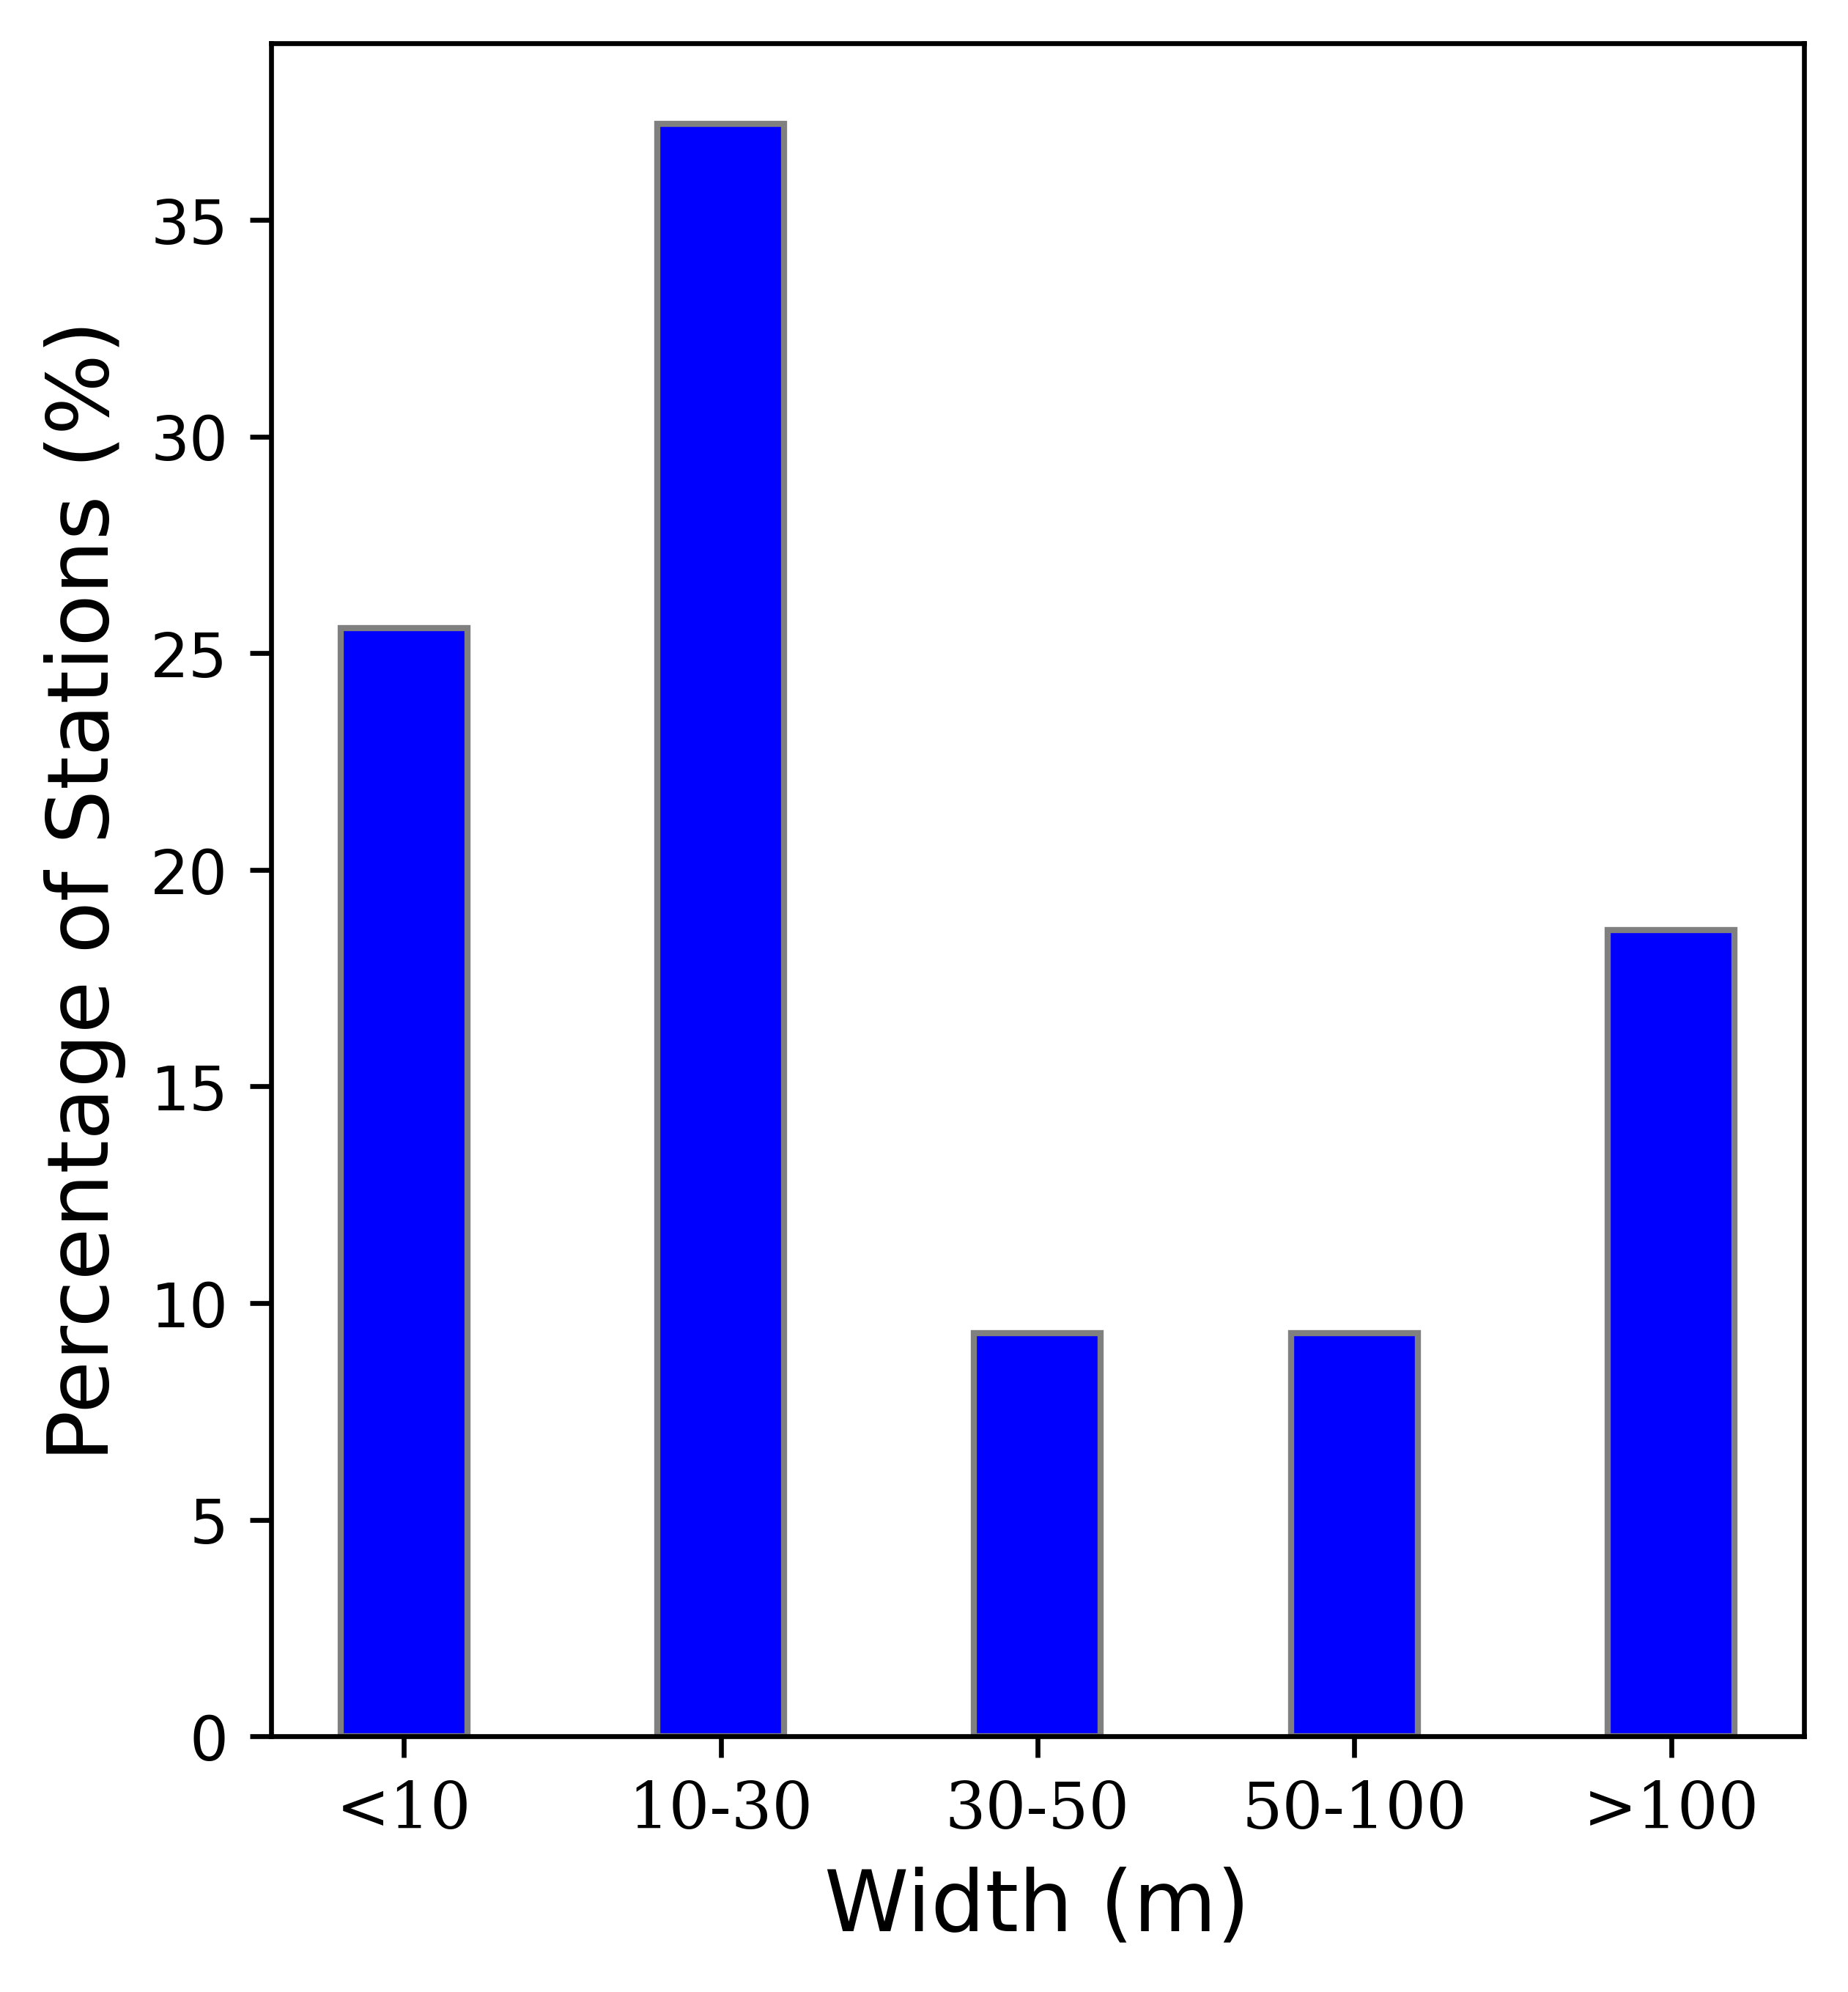

In [79]:
# station width numbers
def wid_range():
    r_tiff = 1/3600*size
    wid_situ  = np.full(np.shape(lon_situ)[0],np.nan)
    for situ in range(0,np.shape(lat_situ)[0]):
        if (lat_situ[situ]>=lat_min) & (lat_situ[situ]<=lat_max) & (lon_situ[situ]>=lon_min) & (lon_situ[situ]<=lon_max):
            lat_num   = round((lat_situ[situ]-lat_max)/-r_tiff)-1
            lon_num   = round((lon_situ[situ]-lon_min)/r_tiff)
            wid_situ[situ]  = wid_low[lat_num,lon_num]*size
    wid_situ = np.where(wid_situ<0,np.nan,wid_situ)
    wid_num1 = np.shape(np.where(wid_situ<10))[1]
    wid_num2 = np.shape(np.where((wid_situ<30) & (wid_situ>10)))[1]
    wid_num3 = np.shape(np.where((wid_situ<50) & (wid_situ>30)))[1]
    wid_num4 = np.shape(np.where((wid_situ<100) & (wid_situ>50)))[1]
    wid_num5 = np.shape(np.where(wid_situ>100))[1]
    wid_num  = [wid_num1,wid_num2,wid_num3,wid_num4,wid_num5]
    wid_rate = wid_num/np.sum(wid_num)*100
    return wid_situ,wid_rate
    
print(wid_num) 
wid_label = ['<10','10-30','30-50','50-100','>100']
wid_situ,wid_rate = wid_range()
fig,ax = plt.subplots(dpi=600,figsize=(4.5,5))
def plot_rate_bar(ax,data,ylabel,color,fontsize):
    wid = 0.3
    x = np.arange(len(wid_label))
    ax.bar(x*0.75,data,color=color,width=wid,edgecolor='gray')
    ax.set_xticks(x*0.75)
    ax.set_xticklabels(wid_label,fontdict=font_label)
    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.set_xlabel('Width (m)',fontsize=fontsize)
plot_rate_bar(ax,wid_rate,'Percentage of Stations (%)',['blue'],14)
plt.savefig('/work/a06/yingying/swot/plot/1_wid_station.jpg', format='jpg',dpi=600)
# plt.show()

In [28]:
#%% calculate RMSE
obs_ref = np.nanmean(obs,axis=1)
obs_wse = obs+ref_situ[:,np.newaxis]
obs_wse = np.where(obs_wse<-999,np.nan,obs_wse)
qual_filter = 18000
obs_wse = np.where((quawse>qual_filter)|(quaarea>qual_filter)|(quasig>qual_filter),np.nan,obs_wse)
sat_wse = np.where((quawse>qual_filter)|(quaarea>qual_filter)|(quasig>qual_filter),np.nan,wse)
diff_mean = np.nanmean(sat_wse)-np.nanmean(obs_wse)
def cal_rmse(obs_wse,sat_wse):
    rmse = np.sqrt(np.nanmean((obs_wse-sat_wse)**2))
    return rmse
rmse_wse = cal_rmse(obs_wse,sat_wse)
def cal_nse(obs_wse,sat_wse):
    upper = np.nansum((obs_wse-sat_wse)**2)
    bottom = np.nansum((obs_wse-np.nanmean(obs_wse))**2)
    nse = 1-upper/bottom
    return nse
nse_wse = cal_nse(obs_wse,sat_wse)
print('mean',diff_mean,'rmse',rmse_wse,'nse',nse_wse)

/tmp/ipykernel_178086/869873714.py:2: RuntimeWarning: Mean of empty slice
  obs_ref = np.nanmean(obs,axis=1)


mean 51.68817625470638 rmse 128.80217803381726 nse 0.1853298829991301


In [29]:
qual_label = ['0','2','4','6','128+2','128+6','256+0','256+2','256+4','256+6','256+128+2','256+128+6','4096+0','4096+2','4096+4','4096+6','4096+128+6',
              '8192+0','8192+6','8192+128+6','8192+4096+6','8192+4096+128+6','16384+4102+6']
qual_flag_type = [0,2,4,6,130,134,256,258,260,262,386,390,4096,4098,4100,4102,4230,8192,8198,8326,12294,12422,20492]
qual_no6 = [0,2,4,130,256,258,260,386,4096,4098,4100,8192]
color_no6 = [22,21,20,18,16,15,14,12,10,9,8,5]

In [30]:
#%% filter out the bad measurements
def filter_wse():
    obs_good = np.where((~np.isin(quawse, qual_no6)) | (~np.isin(quaarea, qual_no6)) | (~np.isin(quasig, qual_no6)),
    np.nan,obs_wse)
    wse_good = np.where((~np.isin(quawse, qual_no6)) | (~np.isin(quaarea, qual_no6)) | (~np.isin(quasig, qual_no6)),
    np.nan,sat_wse)
    diff_filter_mean = np.nanmean(wse_good)-np.nanmean(obs_good)
    rmse_filter_wse = cal_rmse(obs_good,wse_good)
    nse_filter_wse  = cal_nse(obs_good,wse_good)
    print('mean',diff_filter_mean,'rmse',rmse_filter_wse,'nse',nse_filter_wse)
    return obs_good,wse_good
obs_good,wse_good = filter_wse()

def cal_rmse_situ(obs_good,wse_good):
    rmse_all = list()
    for i in range(0,np.shape(obs_wse)[0]):
        rmse_situ = cal_rmse(obs_good[i,:],wse_good[i,:])
        rmse_all  = rmse_all + [rmse_situ]
    return rmse_all
rmse_good = cal_rmse_situ(obs_good,wse_good)
    
def draw_rmse_Japan():
    fig = plt.figure(dpi = 600,figsize=(7.5,4.5))
    ax1 = fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
    ax1.set_axis_off()
    ax1.set_extent([128,149,30,46], ccrs.PlateCarree())
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.5, color='gray', alpha=0, linestyle='-.')
    ax1.coastlines(alpha=1.,linestyle='-',color = "#3F3A3A",lw=0.5,resolution='10m')

    # mask the other place
    region_lon1 = [128.06, 128.06,138, 138 ]
    region_lat1 = [41 , 45.95 , 45.95, 41  ]
    region_lon2 = [128.06,128.06,131.4,131.4 ]
    region_lat2 = [34.5,41,41,34.5]
    ax1.fill(region_lon1, region_lat1, color='white', transform=ccrs.PlateCarree(), zorder=10)
    ax1.fill(region_lon2, region_lat2, color='white', transform=ccrs.PlateCarree(), zorder=10)
    
    gl.top_labels   = False
    gl.right_labels = False
    gl.bottom_labels   = False
    gl.left_labels = False
    con_plot1 = ax1.scatter(lon_situ,lat_situ,c=rmse_good,s=18,zorder=3,cmap='Blues_r',transform=ccrs.PlateCarree(),alpha=0.9,edgecolor='grey',lw=0.3,vmin=0,vmax=5) 
    cmap_blue = ListedColormap(['blue']) 
    # up_low_plot = np.where(np.isnan(up_low),np.nan,2.5)
    # ax1.pcolormesh(lon2d_low_map,lat2d_low_map,up_low_plot,cmap=cmap_blue,zorder=2, transform=ccrs.PlateCarree(),alpha=0.8)  

    def color_bar(l,b,w,h):
      rect = [l,b,w,h]
      cbar_ax = fig.add_axes(rect)
      return cbar_ax
    [l1,b1,w1,h1] = [0.69,0.4,0.01,0.25]
    cbar_ax1 = color_bar(l1,b1,w1,h1)
    cb1 = plt.colorbar(con_plot1, cax=cbar_ax1,orientation="vertical",shrink=0.5)
    cb1.ax.set_title('RMSE $(m)$',fontdict=font_label)
    # plt.show()
    plt.savefig('/work/a06/yingying/swot/plot/7_rmse_Japan.jpg', format='jpg',dpi=600)
    plt.close()

draw_rmse_Japan()

mean 6.002487764088578 rmse 42.635932913000914 nse 0.7968750327730654


/tmp/ipykernel_178086/869873714.py:10: RuntimeWarning: Mean of empty slice
  rmse = np.sqrt(np.nanmean((obs_wse-sat_wse)**2))


In [32]:
#%% observation comparison in different uparea group
def upobs_group():
    rmse_all = cal_rmse_situ(obs_wse,sat_wse)
    rmse_filter = np.where(up_obs<100|np.isnan(up_obs),np.nan,rmse_all)
    rmse_filter_good = np.where(up_obs<100|np.isnan(up_obs),np.nan,rmse_good)
    uprange = [100,500,1000,1500]
    rmse_bar = list()
    rmse_good_bar = list()
    for i in range(0,len(uprange)):
        up1 = uprange[i]
        if i+1<=len(uprange)-1:
            up2 = uprange[i+1]
            rmse_range = np.where((up_obs<up1)|(up_obs>=up2),np.nan,rmse_filter)
            rmse_range_good = np.where((up_obs<up1)|(up_obs>=up2),np.nan,rmse_filter_good)
        else:
            rmse_range = np.where(up_obs<=up1,np.nan,rmse_filter)
            rmse_range_good = np.where(up_obs<=up1,np.nan,rmse_filter_good)
        num = np.shape(np.where(~np.isnan(rmse_range)))[1]
        print('group num:',num)
        rmse_mean = np.nanmean(rmse_range)
        rmse_mean_good = np.nanmean(rmse_range_good)
        print(rmse_mean,rmse_mean_good)
        rmse_bar = rmse_bar + [rmse_mean]
        rmse_good_bar = rmse_good_bar + [rmse_mean_good]
    return rmse_bar, rmse_good_bar
rmse_bar, rmse_good_bar = upobs_group()     

def plot_rmse_bar():
    fig,ax = plt.subplots(dpi = 600,figsize=(10,4.5))
    bar_label = ['100-500','500-1000','1000-1500','>1500']
    bar_width = 0.2
    x = np.arange(0,len(bar_label))
    # ax.spines['top'].set_visible(False) 
    # ax.spines['right'].set_visible(False)  
    # ax.spines['left'].set_visible(True)   
    # ax.spines['bottom'].set_visible(True)
    ax.set_xlabel('Upstream Areas '+r"($\mathrm{m^2}$)",fontdict=font_biglabel)
    ax.set_ylabel('RMSE '+r"($\mathrm{m}$)",fontdict=font_biglabel)
    ax.bar(x-bar_width/2,rmse_bar,width=bar_width,color='yellow',edgecolor='grey',label='Unfiltered measurements')     
    ax.bar(x+bar_width/2,rmse_good_bar,width=bar_width,color='blue',edgecolor='grey',label='Filtered bad quality flags')  
    ax.set_xticks(x)
    ax.set_xticklabels(bar_label,fontdict = font_label)
    plt.legend(fontsize=13.5)
    # plt.show()
    plt.savefig('/work/a06/yingying/swot/plot/6_RMSE_bar.jpg', format='jpg',dpi=600)
    plt.close()
plot_rmse_bar()

/tmp/ipykernel_178086/869873714.py:10: RuntimeWarning: Mean of empty slice
  rmse = np.sqrt(np.nanmean((obs_wse-sat_wse)**2))


group num: 69
72.66755086012326 21.71466506806646
group num: 31
67.1248650574548 8.811526589747219
group num: 7
96.27532575831457 4.766760259297354
group num: 18
99.74246121704317 1.473927005829047


filter: 0.9351052655614924


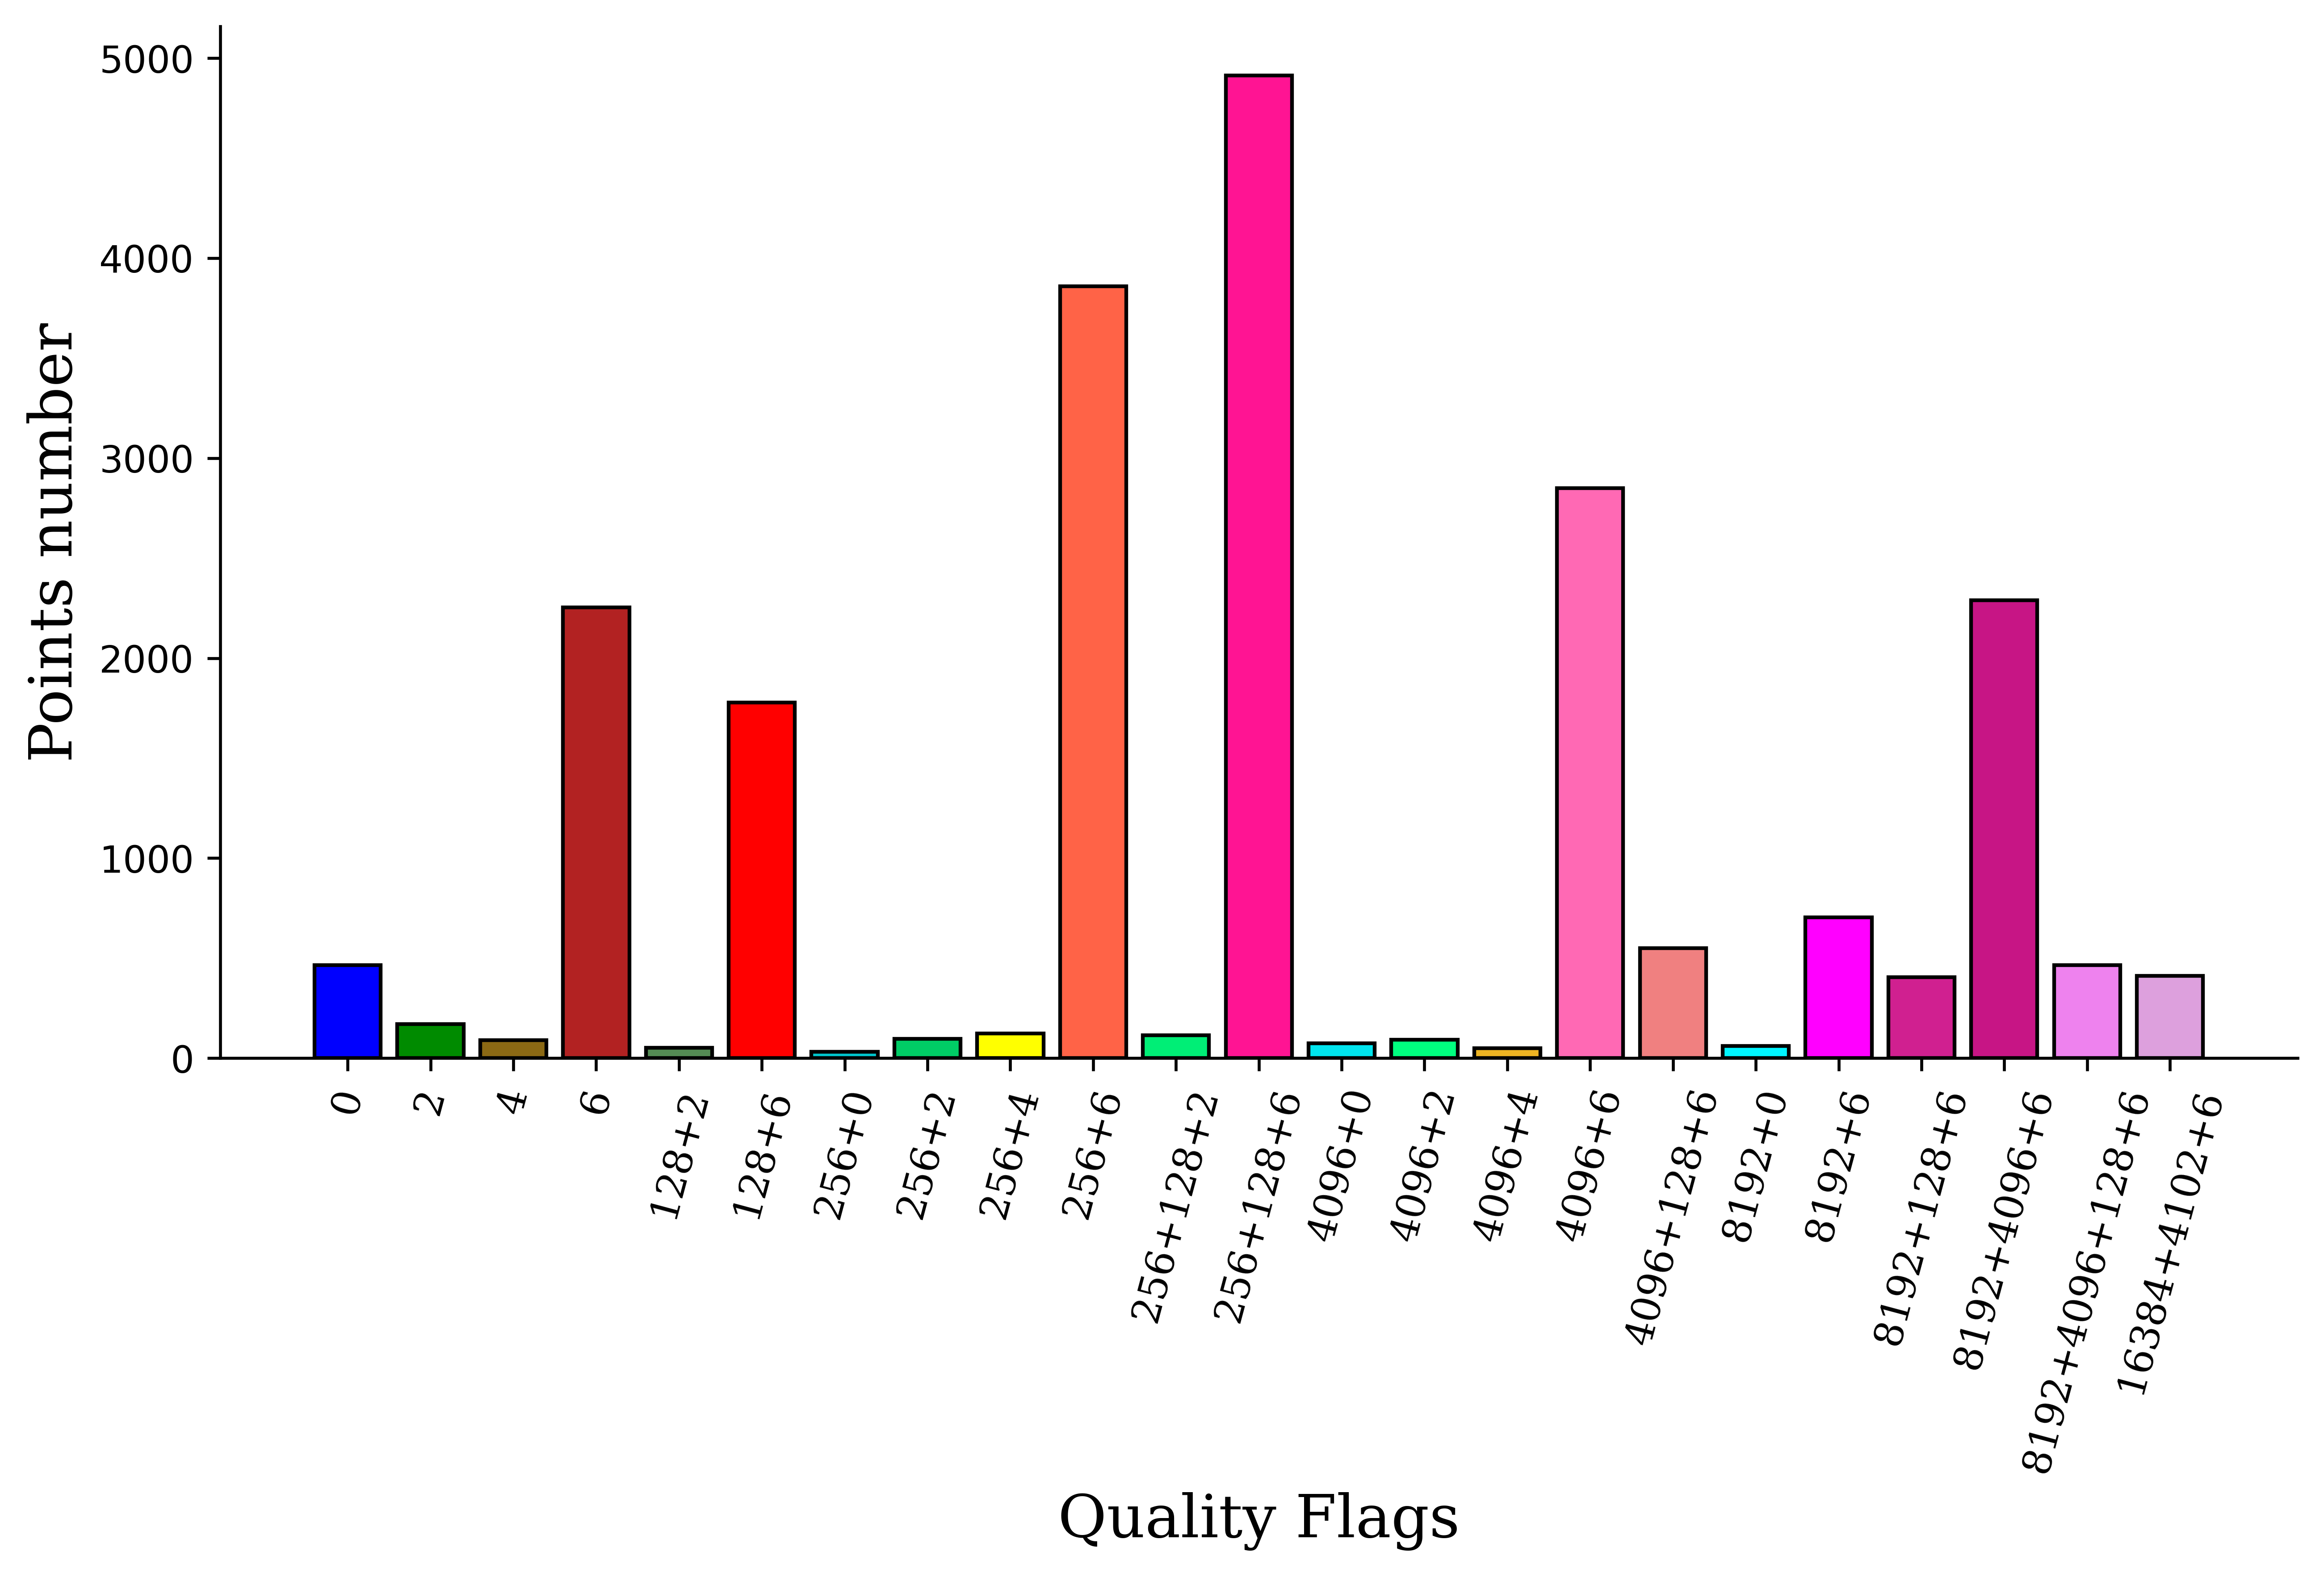

sum grids 21897 0.16280769055121705


In [33]:
#%% Figure: frequency of each type
hex_colors = ['#0000FF','#008B00','#8B6914','#B22222',
             '#548B54','#FF0000',
             '#00C5CD','#00CD66','#FFFF00','#FF6347','#00EE76','#FF1493',
             '#00E5EE','#00FF7F','#EEB422','#FF69B4','#F08080',
             '#00F5FF','#FF00FF','#D02090','#C71585','#EE82EE','#DDA0DD']
hex_colors_ori = hex_colors
hex_colors = hex_colors[::-1]
def plot_bar():
    fig,ax = plt.subplots(dpi = 600,figsize=(10,5))
    value = [466,170,89,2254,53,1777,31,96,124,3859,114,4912,75,93,49,2850,549,61,705,405,2290,464,411]
    qual_label = ['0','2','4','6','128+2','128+6','256+0','256+2','256+4','256+6','256+128+2','256+128+6','4096+0','4096+2','4096+4','4096+6','4096+128+6',
                  '8192+0','8192+6','8192+128+6','8192+4096+6','8192+4096+128+6','16384+4102+6']
    filter_value = [2254,1777,3859,4912,2850,549,705,405,2290,464,411]
    x = np.arange(0,len(value))
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False)  
    ax.spines['left'].set_visible(True)   
    ax.spines['bottom'].set_visible(True)
    ax.set_ylabel('Points number',fontdict=font_title)
    ax.set_xlabel('Quality Flags',fontdict=font_title)
    bar = ax.bar(x, value, color=hex_colors_ori,edgecolor='black',lw=1)
    ax.set_xticks(x)
    ax.set_xticklabels(qual_label,rotation=75,fontdict = font_label)
    print('filter:',np.sum(filter_value)/np.sum(value))
    plt.show()
    # plt.savefig('/work/a06/yingying/swot/plot/6_bar.jpg', format='jpg',dpi=600)
    print('sum grids',sum(value),sum([466,170,89,2254,53,31,96,124,114,75,93])/sum(value))
    plt.close()
plot_bar()



235


/tmp/ipykernel_178086/759469302.py:54: RuntimeWarning: Mean of empty slice
  diff_mean_all = np.nanmean(sat_only_value)-np.nanmean(obs_only_value)
/tmp/ipykernel_178086/869873714.py:10: RuntimeWarning: Mean of empty slice
  rmse = np.sqrt(np.nanmean((obs_wse-sat_wse)**2))
/tmp/ipykernel_178086/869873714.py:15: RuntimeWarning: Mean of empty slice
  bottom = np.nansum((obs_wse-np.nanmean(obs_wse))**2)
/tmp/ipykernel_178086/869873714.py:16: RuntimeWarning: invalid value encountered in scalar divide
  nse = 1-upper/bottom


20486.0 mean nan rmse nan nse nan
how many points: 411


/tmp/ipykernel_178086/869873714.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  nse = 1-upper/bottom


12422.0 mean 31.533485252914744 rmse 71.04311464205638 nse 0.6252697254942612
how many points: 464
12294.0 mean 206.43123966268612 rmse 279.09565804781784 nse -2.228332773285466
how many points: 2290
8326.0 mean 16.935803562014456 rmse 69.66624094271218 nse 0.6678689668348088
how many points: 405
8198.0 mean 100.28831897008259 rmse 193.10503199720472 nse -0.9913457933867453
how many points: 706
8192.0 mean -23.56229687418406 rmse 48.084567658880935 nse -0.31275082259241693
how many points: 61
4230.0 mean 18.077549530137603 rmse 59.33751476963999 nse 0.8542268313996392
how many points: 549
4102.0 mean 124.2038541962948 rmse 212.26699720640136 nse -0.5186971673479892
how many points: 2856
4100.0 mean 32.341147013115574 rmse 114.07636437362869 nse 0.24799008609110962
how many points: 49
4098.0 mean 49.919315963563434 rmse 146.51490775072313 nse 0.5171073586831333
how many points: 93
4096.0 mean -0.2397855053121849 rmse 2.8395834652141017 nse 0.7249645361374067
how many points: 75
390.0 me

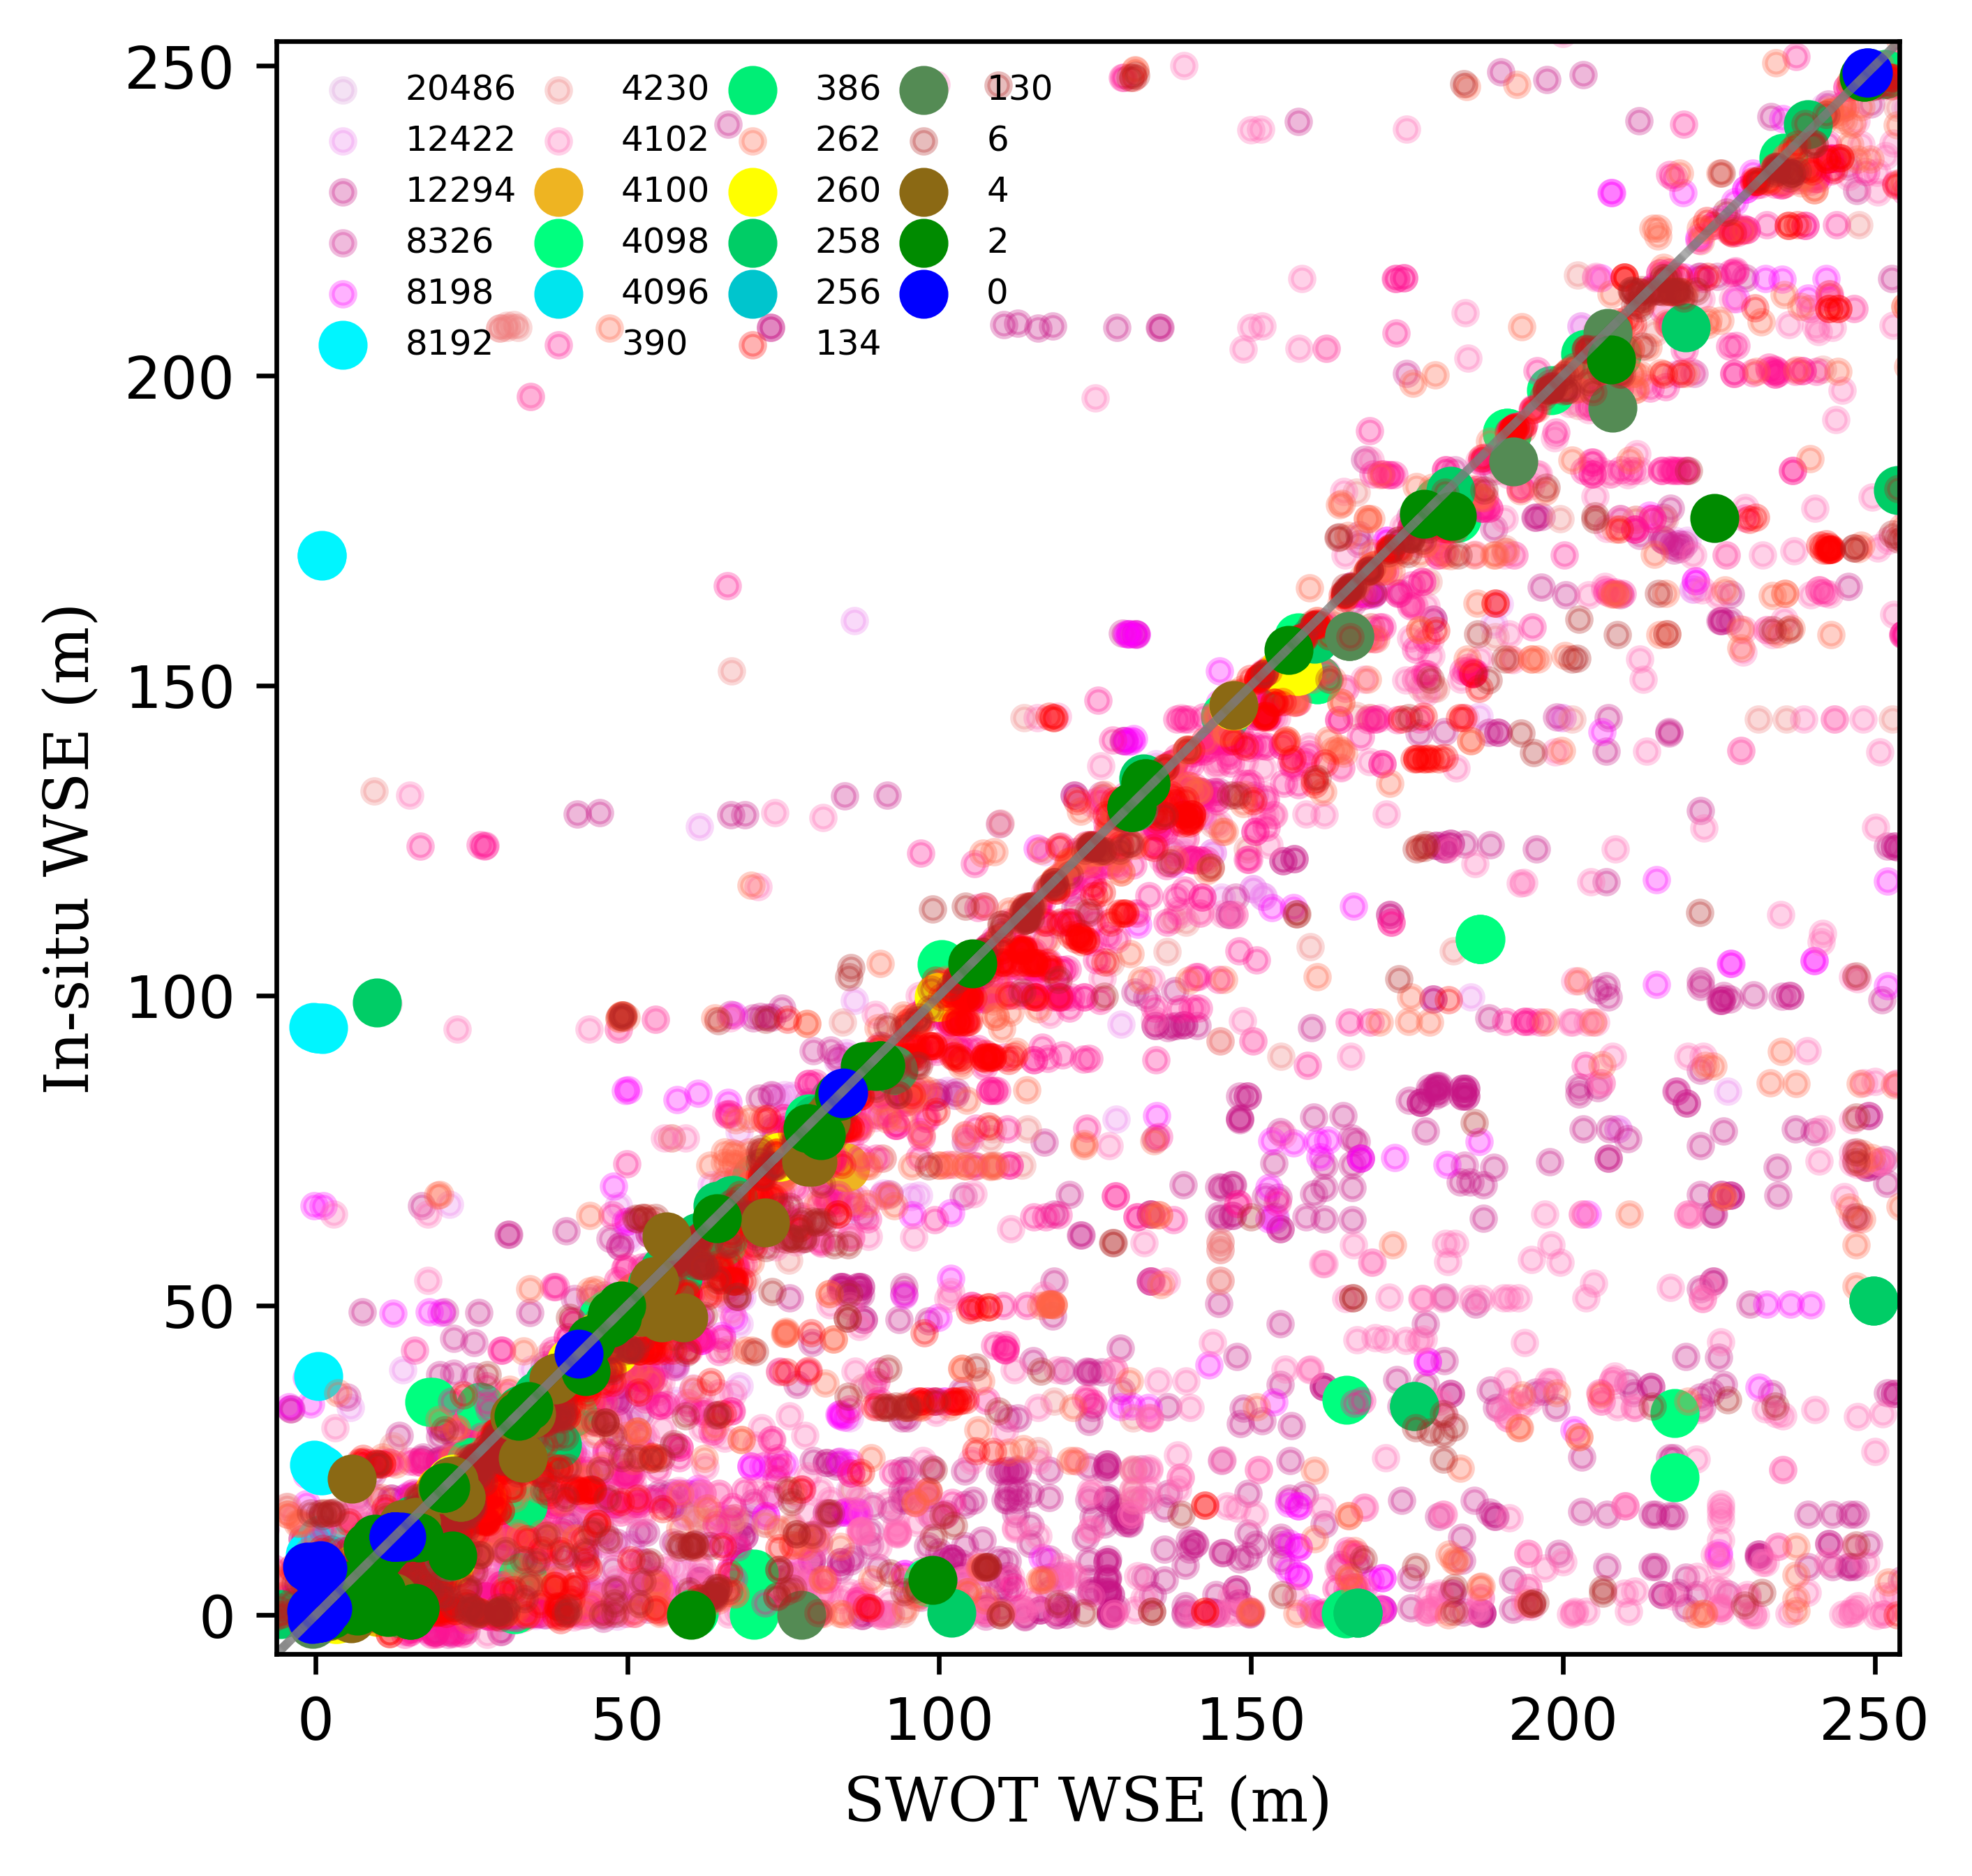

In [34]:
#%% Figure2: Anomaly WSE comparison scatter
flag1 = np.unique(quawse)
flag2 = np.unique(quaarea)
flag3 = np.unique(quasig)
qual_all = np.full((np.shape(quawse)[0],max(len(flag1),len(flag2),len(flag3))),np.nan)
qual_all[0,0:len(flag1)] = flag1
qual_all[1,0:len(flag2)] = flag2
qual_all[2,0:len(flag3)] = flag3
qual_type = np.unique(qual_all)
# np.save('flag_type.npy',np.array(qual_type,dtype=np.int32))
qual_ctrl = np.where(qual_type<32768)[0][-1]
print(qual_ctrl)

cmap = plt.cm.tab20
qual_label = ['0','2','4','6','128+2','128+6','256+0','256+2','256+4','256+6','256+128+2','256+128+6','4096+0','4096+2','4096+4','4096+6','4096+128+6',
              '8192+0','8192+6','8192+128+6','8192+4096+6','8192+4096+128+6','16384+4102+6']
qual_label = qual_label[::-1]
# colors = [cmap(i) for i in range(40)]
# Convert these colors to hexadecimal
# hex_colors = [mcolors.rgb2hex(color) for color in colors]

colors = [tuple(int(x * 255) for x in to_rgb(color)) for color in hex_colors]


def delete_wse_nan(obs_plot,sat_plot):
    obs_wlv  = obs_plot[:,~np.all(np.isnan(sat_plot),axis=0)]
    sat_wlv  = sat_plot[:,~np.all(np.isnan(sat_plot),axis=0)]
    sat_line = sat_wlv.reshape(1,np.shape(sat_wlv)[0]*np.shape(sat_wlv)[1])
    obs_line = obs_wlv.reshape(1,np.shape(obs_wlv)[0]*np.shape(obs_wlv)[1])
    sat_only_value = np.delete(sat_line,np.where(np.isnan(sat_line)))
    obs_only_value = np.delete(obs_line,np.where(np.isnan(sat_line)))
    return obs_wlv,sat_wlv,sat_only_value,obs_only_value

def plot_wlv_comparison(obs,sat):
    wse_adiff_point = np.full((5000,len(hex_colors)),np.nan)  # [qual_nums,qual_types]
    fig,ax = plt.subplots(dpi = 600,figsize=(5,5))
    def plot_wlv_scatter(ax,obs,sat,qual):
        flag = qual_type[qual]
        ax.set_xlabel('SWOT WSE (m)',fontdict=font_label)
        ax.set_ylabel('In-situ WSE (m)',fontdict=font_label)
        if int(flag) == 7:
            obs_plot = np.where((quasig!=flag),np.nan,obs)
            sat_plot = np.where((quasig!=flag),np.nan,sat)
        if int(flag) == 8|10|12|14:
            obs_plot = np.where((quaarea!=flag),np.nan,obs)
            sat_plot = np.where((quaarea!=flag),np.nan,sat)
        if (int(flag) >= 256) & (int(flag) < 10**3):
            obs_plot = np.where((quaarea!=flag)|(quasig!=flag),np.nan,obs)
            sat_plot = np.where((quaarea!=flag)|(quasig!=flag),np.nan,sat)            
        else:
            obs_plot = np.where((quawse!=flag)|(quaarea!=flag)|(quasig!=flag),np.nan,obs)
            sat_plot = np.where((quawse!=flag)|(quaarea!=flag)|(quasig!=flag),np.nan,sat)
        obs_wlv,sat_wlv,sat_only_value,obs_only_value = delete_wse_nan(obs_plot,sat_plot)
        diff_mean_all = np.nanmean(sat_only_value)-np.nanmean(obs_only_value)
        rmse_all = cal_rmse(obs_only_value,sat_only_value)
        nse_all  = cal_nse(obs_only_value,sat_only_value)
        if np.shape(sat_only_value)[0]<30:
            return [-999],[-999],None,None,flag,None
        else:
            print(flag,'mean',diff_mean_all,'rmse',rmse_all,'nse',nse_all)
            print('how many points:',np.shape(sat_only_value)[0])
            point_num = np.shape(sat_only_value)[0]
            ## check absolute result
            # for number in range(0,np.shape(sat_line)[1]):
            #     if np.abs(sat_line[0,number]-obs_line[0,number])>5:
            #         print('swot,obs,diff',sat_line[0,number],obs_line[0,number],sat_line[0,number]-obs_line[0,number])
            #         print(id_info[int(np.unravel_index(number,np.shape(sat_wlv))[0])])
            axis_min = np.nanmin([obs_plot,sat_plot])-5
            axis_max = np.nanmax([obs_plot,sat_plot])+5
            if (~np.isnan(axis_min))&(~np.isnan(axis_max)):
                ax.plot([axis_min,axis_max],[axis_min,axis_max],linestyle='--',color='gray',alpha=0.1)
                ax.set_xlim(axis_min,axis_max)
                ax.set_ylim(axis_min,axis_max)
                # print(cal_rmse(obs_plot-sat_plot))
            return sat_plot,obs_plot,sat_only_value,obs_only_value,flag,point_num
    obs_bad = np.where((quawse<qual_type[qual_ctrl])&(quaarea<qual_type[qual_ctrl])&(quasig<qual_type[qual_ctrl]),np.nan,obs)
    sat_bad = np.where((quawse<qual_type[qual_ctrl])&(quaarea<qual_type[qual_ctrl])&(quasig<qual_type[qual_ctrl]),np.nan,sat)
    # ax.scatter(sat_bad,obs_bad,color='grey',s=0.05,alpha=0.4,label='flag>8198')#+str(int(qual_type[qual_ctrl-1]))
    # all types
    def plot_all_flags(qual2,qual1,filen,color_ind):
        flag_plot = list()
        for qual in range(qual2,qual1,-1):
            sat_plot,obs_plot,sat_only_value,obs_only_value,flag,point_num = plot_wlv_scatter(ax,obs,sat,qual)  
            if np.array_equal(sat_plot, np.array([-999])):
                continue
            # sat-obs measurement
            wse_adiff_point[0:point_num,color_ind] = sat_only_value-obs_only_value
            if np.isin(flag,qual_no6):
                ax.scatter(sat_plot,obs_plot,s=55,c=hex_colors[color_ind],alpha=1,label=str(int(flag)))
            else:
                ax.scatter(sat_plot,obs_plot,s=15,c=hex_colors[color_ind],alpha=0.3,label=str(int(flag)))
            color_ind = color_ind+1
            flag_plot = flag_plot + [int(qual_type[qual])]
        print('how many types of quality flag:',color_ind)
        plt.legend(ncol=4,loc='upper left',fontsize=6, columnspacing=0.2, frameon=False)
        plt.show()
        # plt.savefig('/work/a06/yingying/swot/plot/'+filen, format='jpg',dpi=600)
        plt.close()
        return flag_plot
    flag_plot = plot_all_flags(qual_ctrl-1,0-1,'2_Comparison_wse.jpg',0)

    # specific types
    def plot_specific_flag(flag_ind):
        fig,ax = plt.subplots(dpi = 600,figsize=(5,5))
        sat_plot,obs_plot,sat_only_value,obs_only_value,flag,point_num = plot_wlv_scatter(ax,obs,sat,flag_ind)
        ax.set_xlabel('SWOT WSE (m)',fontdict=font_label)
        ax.set_ylabel('In-situ WSE (m)',fontdict=font_label)
        ax.plot([-50,700],[-50,700],linestyle='--',color='gray',alpha=0.8)
        ax.scatter(sat_plot,obs_plot,s=5,c=hex_colors_ori[flag_ind],alpha=1)
        plt.show()
        # plt.savefig('/work/a06/yingying/swot/plot/2_Comparison_wse.jpg', format='jpg',dpi=600)
        plt.close()
    # plot_specific_flag(1) # flag:2  
    # plot_specific_flag(2) # flag:4
    # plot_specific_flag(3) # flag:6  
    return flag_plot,wse_adiff_point
flag_plot,wse_adiff_point = plot_wlv_comparison(obs_wse,wse)

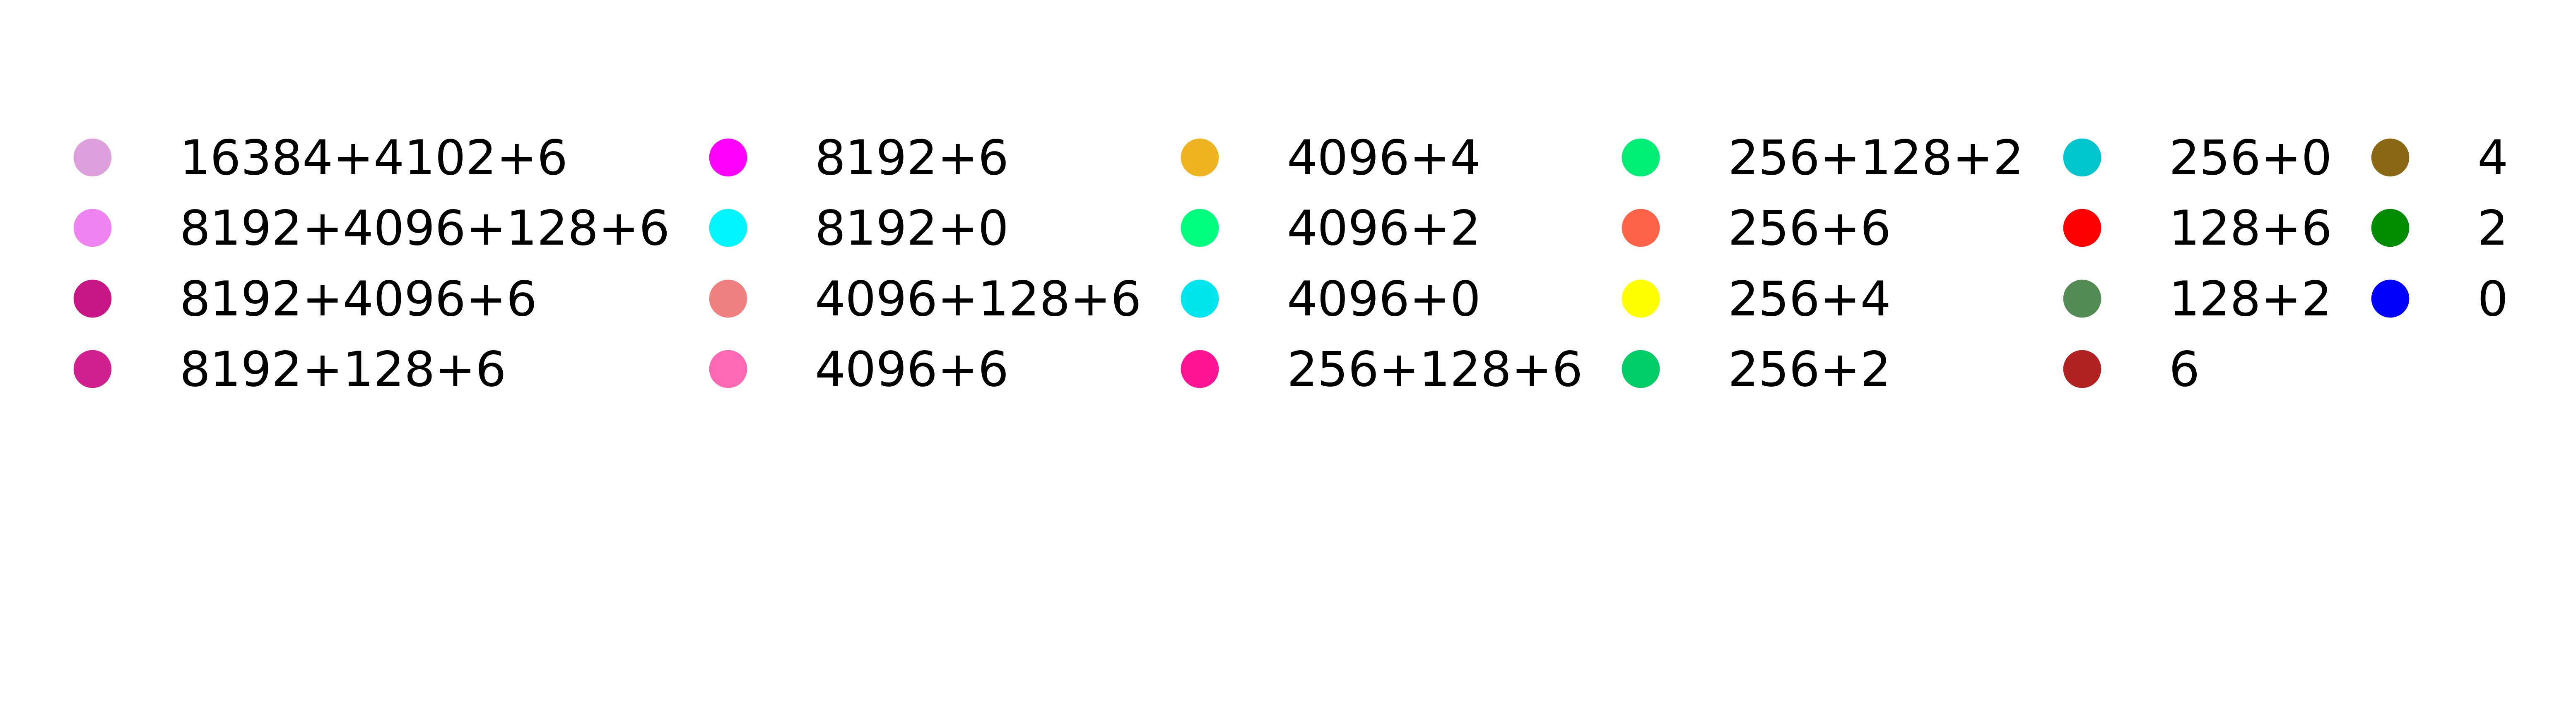

In [35]:
from matplotlib.lines import Line2D
fig = plt.figure(dpi = 600,figsize=(13,3.5))
ax = fig.add_subplot(111)
legend_ax = fig.add_axes([0.8, 0.2, 0.1, 0.6]) 

legend_ele = []  

for i in range(len(qual_label)):
    legend_ele.append(
        Line2D([0], [0], marker='o', color='none', markeredgecolor=hex_colors[i],
               markerfacecolor=hex_colors[i], markersize=10, label=qual_label[i])
    )

ax.axis('off')

legend_ax.axis('off')
legend_ax.legend(handles=legend_ele, loc='best',ncol=6, frameon=False,fontsize=14, columnspacing=0.2)
# plt.savefig('/work/a06/yingying/swot/plot/2_legend.jpg', format='jpg',dpi=600)
plt.show()
plt.close()


In [36]:
#%% WSE from upstream to downstream
flow_dir0 = np.where((flow_dir==247)|(flow_dir==-9)|(flow_dir==-1)|(flow_dir<1)|(flow_dir==255)|(flow_dir>128),np.nan,flow_dir)
def find_next(lat_num,lon_num,h_flow_dir2):
    if h_flow_dir2[lat_num,lon_num] ==1:
        lon_num = lon_num+1
        # h_flow_dir2[lat_num,lon_num-1] = np.nan      
    elif h_flow_dir2[lat_num,lon_num] ==2:
        lat_num = lat_num+1
        lon_num = lon_num+1 
        # h_flow_dir2[lat_num-1,lon_num-1] = np.nan
    elif h_flow_dir2[lat_num,lon_num] ==4:
        lat_num = lat_num+1
        # h_flow_dir2[lat_num-1,lon_num] = np.nan
    elif h_flow_dir2[lat_num,lon_num] ==8:
        lat_num = lat_num+1
        lon_num = lon_num-1 
        # h_flow_dir2[lat_num-1,lon_num+1] = np.nan
    elif h_flow_dir2[lat_num,lon_num] ==16:
        lon_num = lon_num-1
        # h_flow_dir2[lat_num,lon_num+1] = np.nan
    elif h_flow_dir2[lat_num,lon_num] ==32:
        lat_num = lat_num-1
        lon_num = lon_num-1 
        # h_flow_dir2[lat_num+1,lon_num+1] = np.nan
    elif h_flow_dir2[lat_num,lon_num] ==64:
        lat_num = lat_num-1
        # h_flow_dir2[lat_num+1,lon_num] = np.nan
    elif h_flow_dir2[lat_num,lon_num] ==128:
        lat_num = lat_num-1
        lon_num = lon_num+1
        # h_flow_dir2[lat_num+1,lon_num-1] = np.nan
    return lat_num,lon_num,h_flow_dir2

In [37]:
def find_cycle(cycle):
    filenames = []
    for root, dirs, files in os.walk(raster100_path):
        for file in files:
            if file.endswith(".nc"):
                if np.array_equal(file[38:41],cycle):
                    filenames.append(file)
    filelen = len(filenames) 
    print('how many files in',cycle,len(filenames))
    return filelen,filenames
region_file, region_filen = find_cycle('009')
# for i in range(0,18):
#     str_cycle = '{:03d}'.format(i)
#     region_file, region_filen = find_cycle(str_cycle)
    

how many files in 009 6


In [38]:
# find river profile
lat_start,lon_start = 36.820 ,139.195 #Tone River
# lat_start,lon_start = 39.7  ,141.1 #Kitakami River
# lat_start,lon_start = 33.098 ,131.16 #Chikugo River

def find_river(lat_start,lon_start,rivername):
    r_tiff = 1/3600
    # starting point of Tone River (type: 128)
    # [ 35.925 140.129]
    ilat_river = list()
    ilon_river = list()
    wid_river  = list()
    flow_dir2 = copy.deepcopy(flow_dir0)
    lat_num   = round((lat_start-latr_max)/-r_tiff)-1
    lon_num   = round((lon_start-lonr_min)/r_tiff)
    # for lat_num in range(ilat_start-1,ilat_start+2):
    #     for lon_num in range(ilon_start-1,ilon_start+2):
    grid = 0
    while (np.isnan(flow_dir2[lat_num,lon_num])==False):
        # define next grid
        ilat_river = ilat_river + [lat_num]
        ilon_river = ilon_river + [lon_num]
        wid_river  = wid_river  + [wid_region[lat_num,lon_num]]
        lat_num,lon_num,flow_dir2 = find_next(lat_num,lon_num,flow_dir2)
        grid = grid+1
        if lat_num>np.shape(flow_dir)[0]-2:
            break
    lat_river = lat_tiff[ilat_river] 
    lon_river = lon_tiff[ilon_river]
    lat_river_min = np.nanmin(lat_river)
    lat_river_max = np.nanmax(lat_river)
    lon_river_min = np.nanmin(lon_river)
    lon_river_max = np.nanmax(lon_river)
    print(grid)
    np.save('/work/a06/yingying/SWOT/river_width/wid_'+rivername+'.npy',wid_river)
    np.save('/work/a06/yingying/SWOT/river_width/lat_'+rivername+'.npy',lat_river)
    np.save('/work/a06/yingying/SWOT/river_width/lon_'+rivername+'.npy',lon_river)
    return ilat_river,ilon_river,wid_river,lat_river,lon_river,lat_river_min,lat_river_max,lon_river_min,lon_river_max
ilat_river,ilon_river,wid_river,lat_river,lon_river,lat_river_min,lat_river_max,lon_river_min,lon_river_max = find_river(lat_start,lon_start,'Tone')

9415


In [39]:
# search river profile
# ilat_start,ilon_start = 36.820 ,139.195 #Tone River
ilat_start,ilon_start = 39.7  ,141.1 #Kitakami River
# ilat_start,ilon_start = 33.098 ,131.16 #Chikugo River

def search_river(lat_start,lon_start):
    r_tiff = 1/3600
    # starting point of Tone River (type: 128)
    # [ 35.925 140.129]
    lat_river_all = np.zeros((100,20000))
    lon_river_all = np.zeros((100,20000))
    flow_dir2 = copy.deepcopy(flow_dir0)
    for ilat_num in np.arange(ilat_start,ilat_start+0.1,0.01):
        for ilon_num in np.arange(ilon_start-0.1,ilon_start+0.1,0.01):
            lat_num   = round((ilat_num-latr_max)/-r_tiff)-1
            lon_num   = round((ilon_num-lonr_min)/r_tiff)
            ilat_river = list()
            ilon_river = list()
            grid = 0
            row  = 0
            while (np.isnan(flow_dir2[lat_num,lon_num])==False):
                # define next grid
                ilat_river = ilat_river + [lat_num]
                ilon_river = ilon_river + [lon_num]
                lat_num,lon_num,flow_dir2 = find_next(lat_num,lon_num,flow_dir2)
                grid = grid+1
                if lat_num>np.shape(flow_dir)[0]-2:
                    break
            lat_river = lat_tiff[ilat_river] 
            lon_river = lon_tiff[ilon_river]
            if grid>1000:
                lat_river_all[row,0:np.shape(lat_river)[0]] = lat_river
                lon_river_all[row,0:np.shape(lon_river)[0]] = lon_river
                row = row+1
                print(grid)
                print(lat_river)
                print(lon_river)
    return lat_river,lon_river
# lat_river,lon_river = search_river(lat_start,lon_start)

In [40]:
def read_raster_nc(filename,lon_max,lon_min,lat_max,lat_min): 
    # Read each file using netCDF4
    filepath = raster100_path + filename   
    nf = nc.Dataset(filepath,'r')
    glon_min= nf.getncattr('geospatial_lon_min')
    glon_max= nf.getncattr('geospatial_lon_max')
    glat_min= nf.getncattr('geospatial_lat_min')
    glat_max= nf.getncattr('geospatial_lat_max') 
    # if (glon_min<lon_max) & (glon_max>lon_min) & (glat_min<lat_max) & (glat_max>lat_min):
    lat_all = np.array(nf.variables['latitude'])
    lon_all = np.array(nf.variables['longitude'])
    wse_all = np.array(nf.variables['wse'])
    quawse_all = np.array(nf.variables['wse_qual_bitwise'])
    quaarea_all= np.array(nf.variables['water_area_qual_bitwise'])
    quasig_all = np.array(nf.variables['sig0_qual_bitwise'])
    lon_all = np.where(wse_all>10**8,np.nan,lon_all)
    lat_all = np.where(wse_all>10**8,np.nan,lat_all)
    wse_all = np.where(wse_all>10**8,np.nan,wse_all)
    return lat_all,lon_all,wse_all,quawse_all,quaarea_all,quasig_all,glon_min,glon_max,glat_min,glat_max

def find_river_in_raster(lat_all,lon_all,lat_obs,lon_obs):
    lat_1d = lat_all.flatten()
    lon_1d = lon_all.flatten()
    near_index = np.nanargmin((lat_1d-lat_obs)**2+(lon_1d-lon_obs)**2)
    return near_index

def find_obs_along_river():
    index_all = np.full((np.shape(lat_situ)[0],6),np.nan)
    obs_point =  np.full((np.shape(lat_situ)[0],6),np.nan)
    file_count = 0
    for ind in range(0,region_file):
        index = list()
        obs_ind = list()
        for situ in range(0,np.shape(lat_situ)[0]):
            lat_point = lat_situ[situ]
            lon_point = lon_situ[situ]
            if (lat_point>=lat_river_min) & (lat_point<=lat_river_max) & (lon_point>=lon_river_min) & (lon_point<=lon_river_max):
                near_index = find_river_in_raster(lat_river,lon_river,lat_point,lon_point)
                index = index + [near_index]
                obs_ind = obs_ind + [situ]
        index = np.array(index)
        obs_ind = np.array(obs_ind)
        index_all[0:np.shape(index)[0],file_count] = index
        obs_point[0:np.shape(obs_ind)[0],file_count] = obs_ind
        file_count = file_count + 1
        # print('--------')
    return index_all,obs_point
river_index_all,obs_point = find_obs_along_river()

In [41]:
# read files in the same cycle
def find_river_profile():
    wse_river_all = np.full((np.shape(ilat_river)[0],region_file),np.nan)
    lat_river_all = np.full((np.shape(ilat_river)[0],region_file),np.nan)
    lon_river_all = np.full((np.shape(ilat_river)[0],region_file),np.nan)
    quawse_river_all = np.full((np.shape(ilat_river)[0],region_file),np.nan)
    quaarea_river_all = np.full((np.shape(ilat_river)[0],region_file),np.nan)
    quasig_river_all = np.full((np.shape(ilat_river)[0],region_file),np.nan)
    file_count = 0
    for ind in range(0,region_file):
        lat_all,lon_all,wse_all,quawse_all,quaarea_all,quasig_all,glon_min,glon_max,glat_min,glat_max = read_raster_nc(region_filen[ind],lon_river_max,lon_river_min,lat_river_max,lat_river_min)
        # for point in range(0,np.shape(ilat_river)[0]):
        for point in range(0,20):
            lat_point = lat_tiff[ilat_river[point]]
            lon_point = lon_tiff[ilon_river[point]]
            if (lat_point>=glat_min) & (lat_point<=glat_max) & (lon_point>=glon_min) & (lon_point<=glon_max):
                near_index = find_river_in_raster(lat_all,lon_all,lat_river[point],lon_river[point])
                row_ind,col_ind = np.unravel_index(near_index, np.shape(lat_all))
                wse_river_all[point,file_count] = wse_all[row_ind,col_ind]
                lat_river_all[point,file_count] = lat_all[row_ind,col_ind]
                lon_river_all[point,file_count] = lon_all[row_ind,col_ind]
                quawse_river_all[point,file_count] = quawse_all[row_ind,col_ind]
                quaarea_river_all[point,file_count] = quaarea_all[row_ind,col_ind]
                quasig_river_all[point,file_count]  = quasig_all[row_ind,col_ind]
        file_count = file_count + 1
        # print('--------')
    return wse_river_all,lat_river_all,lon_river_all, quawse_river_all, quaarea_river_all, quasig_river_all
wse_river_all,lat_river_all,lon_river_all, quawse_river_all, quaarea_river_all, quasig_river_all = find_river_profile()

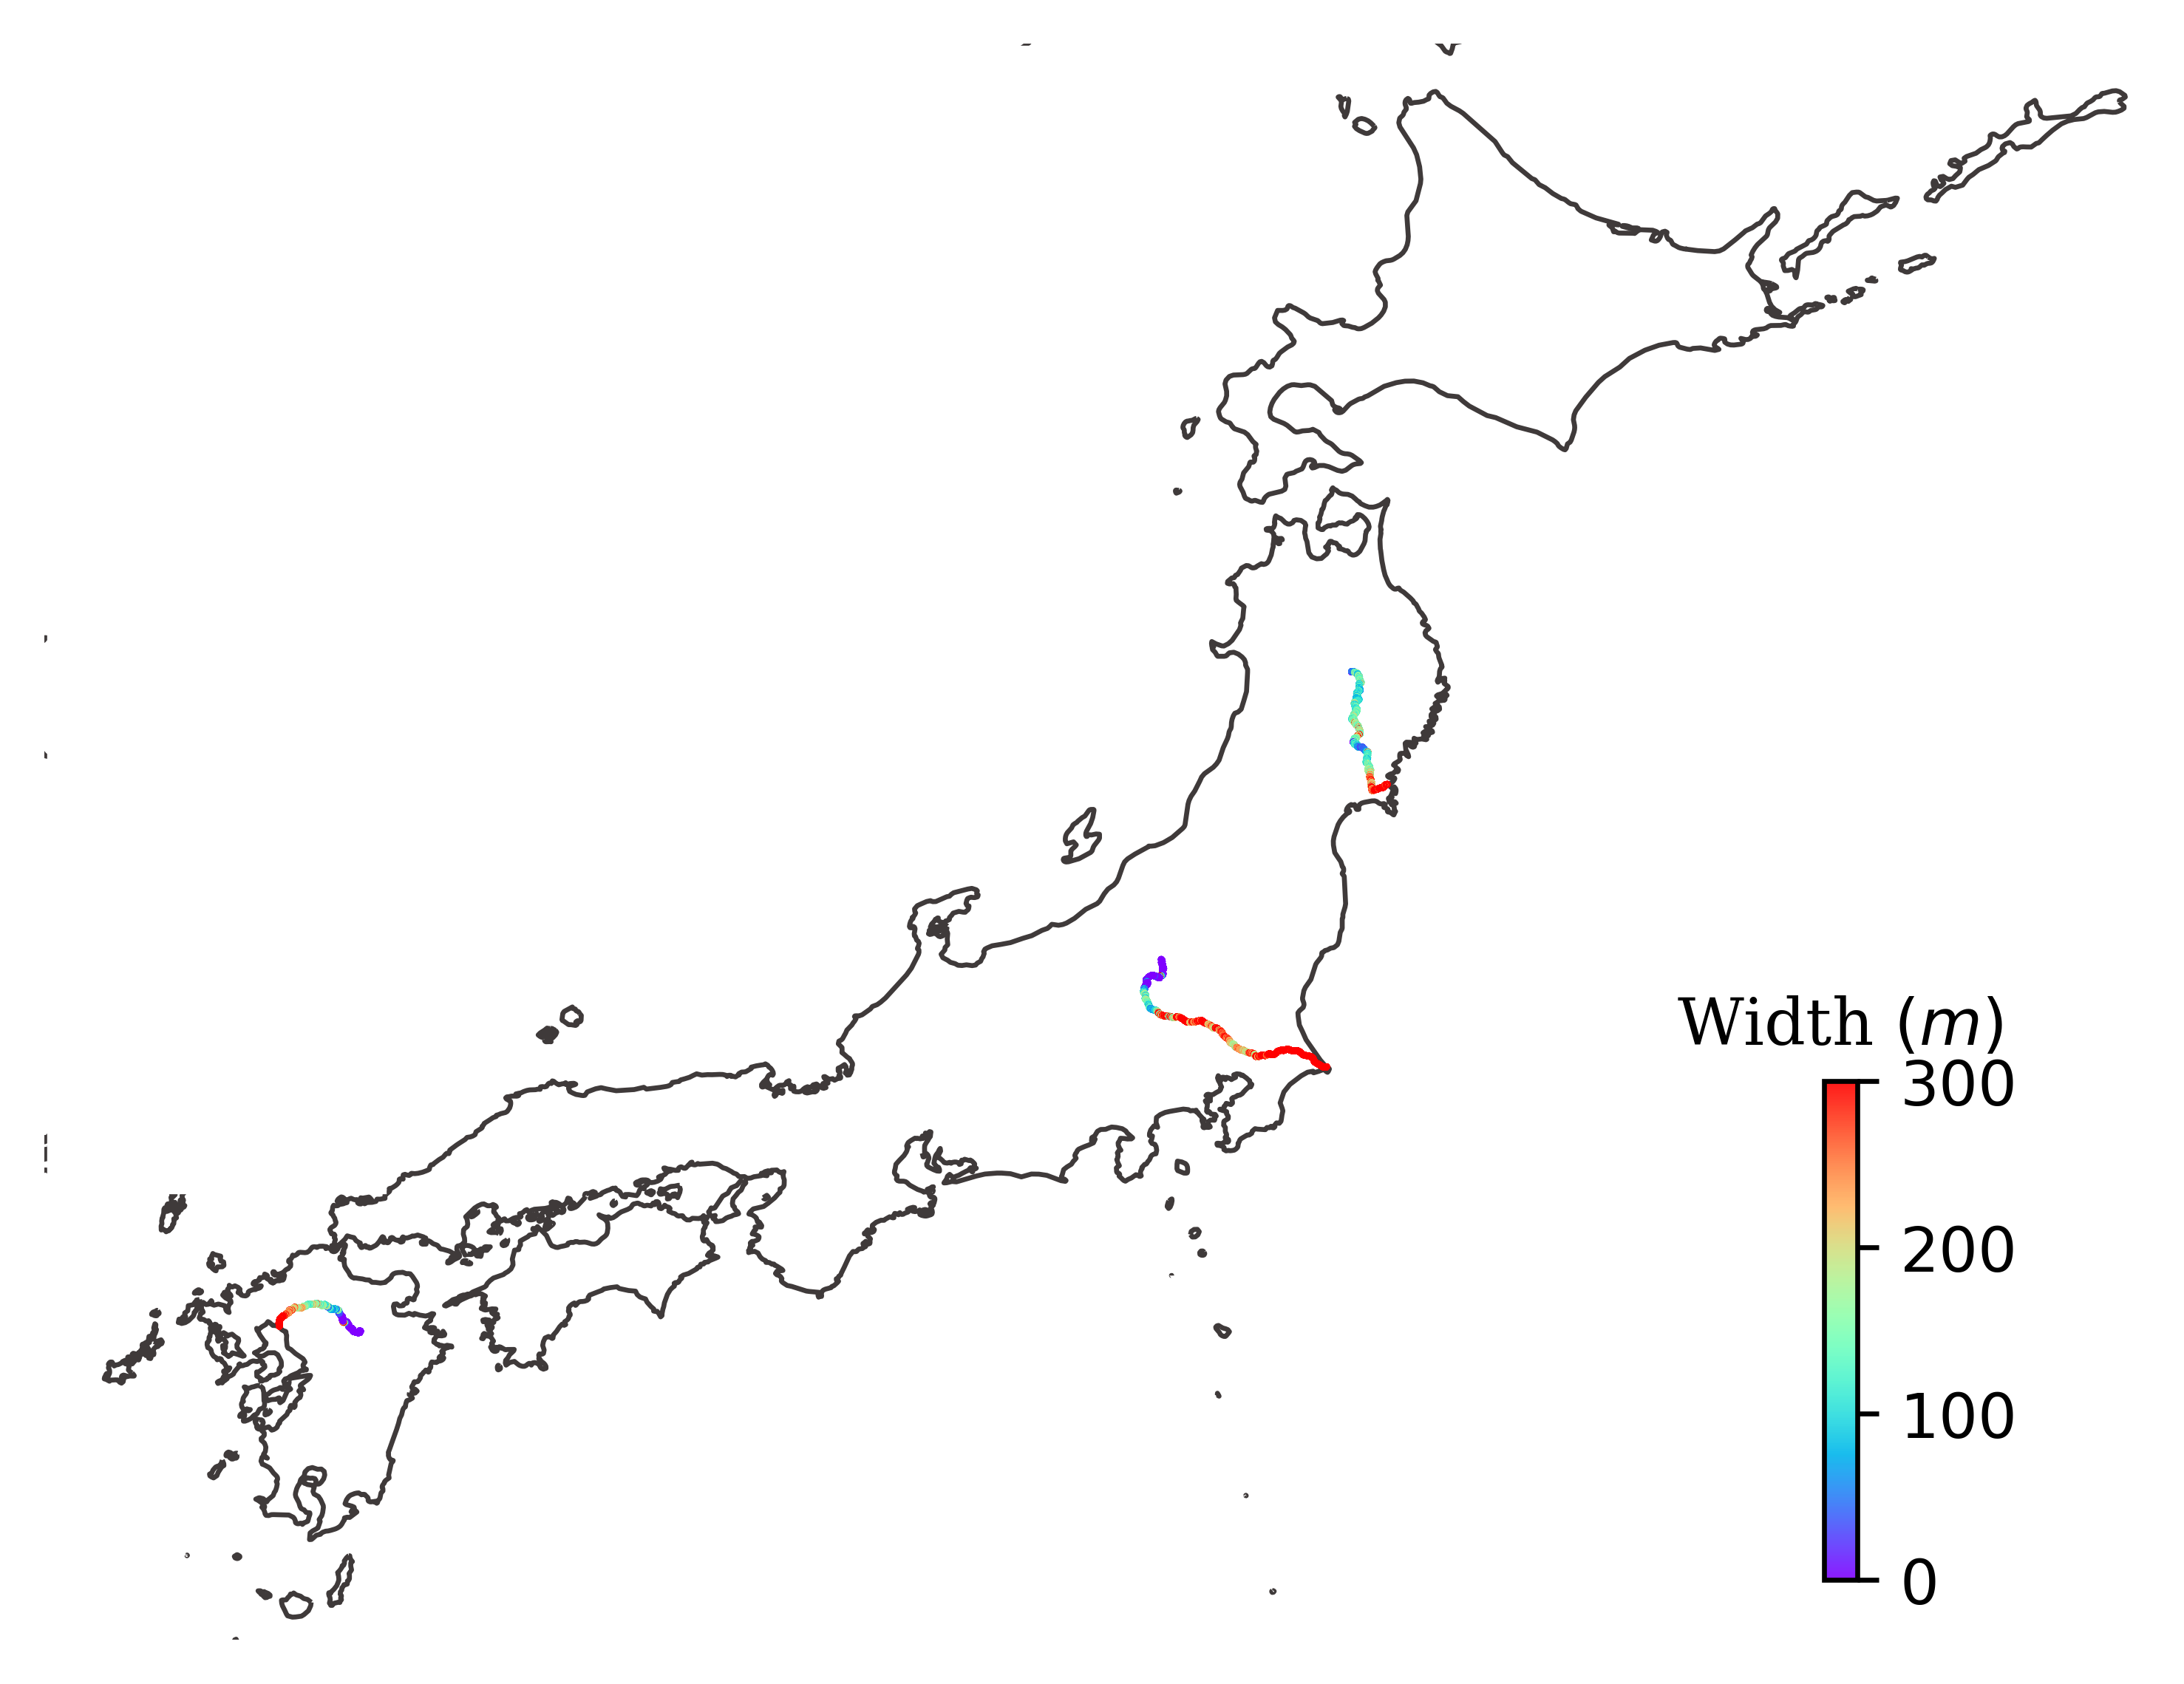

In [42]:
# draw river location map
# Figure6: Japan river map
river_path = '/work/a06/yingying/SWOT/river_width/'
lat_river1 = np.load(river_path+'lat_Tone.npy')
lon_river1 = np.load(river_path+'lon_Tone.npy')
wid_river1 = np.load(river_path+'wid_Tone.npy')
lat_river2 = np.load(river_path+'lat_Kita.npy')
lon_river2 = np.load(river_path+'lon_Kita.npy')
wid_river2 = np.load(river_path+'wid_Kita.npy')
lat_river3 = np.load(river_path+'lat_Chi.npy')
lon_river3 = np.load(river_path+'lon_Chi.npy')
wid_river3 = np.load(river_path+'wid_Chi.npy')
def draw_Japan_rivers():
    fig = plt.figure(dpi = 600,figsize=(7.5,4.5))
    ax1 = fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
    # ax1.set_axis_off()
    ax1.set_extent([128,149,30,46], ccrs.PlateCarree())
    ax1.set_axis_off()
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0., linestyle='-.')
    ax1.coastlines(alpha=1.,linestyle='-',color = "#3F3A3A",lw=0.8,resolution='10m')
    
    gl.top_labels   = False
    gl.right_labels = False
    gl.bottom_labels   = False
    gl.left_labels = False
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

    # mask the other place
    region_lon1 = [128.06, 128.06,138, 138 ]
    region_lat1 = [41 , 45.95 , 45.95, 41  ]
    region_lon2 = [128.06,128.06,131.4,131.4 ]
    region_lat2 = [34.5,41,41,34.5]
    ax1.fill(region_lon1, region_lat1, color='white', transform=ccrs.PlateCarree(), zorder=10)
    ax1.fill(region_lon2, region_lat2, color='white', transform=ccrs.PlateCarree(), zorder=10)
    
    norm = plt.Normalize(vmin=0, vmax=300)
    colors = plt.cm.rainbow(norm(wid_river))
    con_plot1 = ax1.scatter(lon_river1,lat_river1,s=0.01,zorder=3,c=wid_river1,cmap='rainbow',norm=norm,transform=ccrs.PlateCarree(),alpha=0.9) 
    con_plot1 = ax1.scatter(lon_river2,lat_river2,s=0.01,zorder=3,c=wid_river2,cmap='rainbow',norm=norm,transform=ccrs.PlateCarree(),alpha=0.9) 
    con_plot1 = ax1.scatter(lon_river3,lat_river3,s=0.01,zorder=3,c=wid_river3,cmap='rainbow',norm=norm,transform=ccrs.PlateCarree(),alpha=0.9) 

    def color_bar(l,b,w,h):
      rect = [l,b,w,h]
      cbar_ax = fig.add_axes(rect)
      return cbar_ax
    [l2,b2,w2,h2] = [0.72,0.13,0.01,0.25]
    cbar_ax2 = color_bar(l2,b2,w2,h2)
    cb2 = plt.colorbar(con_plot1, norm=norm,cax=cbar_ax2,cmap='rainbow',orientation="vertical",shrink=0.5)
    cb2.ax.set_title('Width $(m)$',fontdict=font_label)
    plt.show()
    # plt.savefig('/work/a06/yingying/swot/plot/6_rivermap.jpg', format='jpg',dpi=600)
    plt.close()

draw_Japan_rivers()

In [43]:
#%% read Tono river location
def read_river(rivername):
    wse_river_all = np.load('/work/a06/yingying/SWOT/save_'+rivername+'/wse_river.npy')
    lat_river_all = np.load('/work/a06/yingying/SWOT/save_'+rivername+'/lat_river.npy')
    lon_river_all = np.load('/work/a06/yingying/SWOT/save_'+rivername+'/lon_river.npy')
    quawse_river = np.load('/work/a06/yingying/SWOT/save_'+rivername+'/quawse_river.npy')
    quaarea_river = np.load('/work/a06/yingying/SWOT/save_'+rivername+'/quaarea_river.npy')
    quasig_river = np.load('/work/a06/yingying/SWOT/save_'+rivername+'/quasig_river.npy')
    return wse_river_all, lat_river_all, lon_river_all, quawse_river, quaarea_river, quasig_river
wse_river_all, lat_river_all, lon_river_all, quawse_river, quaarea_river, quasig_river = read_river('Tone')
# wse_river_all, lat_river_all, lon_river_all, quawse_river, quaarea_river, quasig_river = read_river('Kita')
# wse_river_all, lat_river_all, lon_river_all, quawse_river, quaarea_river, quasig_river = read_river('Chikugo')
print(np.unique(wse_river_all))
print(np.shape(wse_river_all))

[ -16.59797668  -15.0570612   -14.70795345 ...  824.69262695 1394.0690918
           nan]
(9415, 6)


In [49]:
# plot WSE profile
def filter_profile(wse,value):
    wse_q1 = np.nanpercentile(wse,25)
    wse_q3 = np.nanpercentile(wse,75)
    delta  = wse_q3-wse_q1
    if delta == 0:
        data_save = wse
    else:
        lower_bound = wse_q1 - value*delta
        upper_bound = wse_q3 + value*delta
        data_save = np.where((wse<lower_bound)|(wse>upper_bound),np.nan,wse)
    return data_save

def plot_WSE_profile(obs_point):
    font_label = {'family': 'serif', 'weight': 'normal', 'size': 13}
    fig,ax = plt.subplots(dpi = 600,figsize=(10,4))
    ax.set_ylabel('SWOT WSE (m)',fontdict=font_label)
    ax.set_xlabel('From upstream to downstream',fontdict=font_label)
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False) 
    ax.spines['bottom'].set_visible(False) 
    ax.set_ylim(0,610)
    x = np.arange(0,np.shape(ilat_river)[0])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.)
    obs_meas = list()
    swot_meas = list()
    swot_filter_qual = list()
    for i in range(0,np.shape(wse_river_all)[1]):
        qual_type = list()
        obs_color = list()
        swot_point_plot = list()
        obs_point_plot  = list()
        x_point_plot = list()
        swot_qual_plot = list()
        swot_save       = list()
        swot_both_save = list()
        filename = region_filen[i]
        year = filename[51:55]
        mon = filename[55:57]
        day = filename[57:59]
        hr  = filename[60:62]
        mins= filename[62:64]
        if int(mins)>30:
            hr_num = int(hr)+1
            if hr_num>23:
                day_num = int(day)+1
                day= '{:02d}'.format(day_num)
                hr = '00'
            else:
                hr = '{:02d}'.format(hr_num)
        obstime = year+mon+day+hr
        obsname = "/work/a06/yingying/obs/"+year+"UST/wlv/"+year+mon+day+hr+".bin"
        with open(obsname,'rb') as f:
            obs_all = np.fromfile(f, dtype=np.float32)
            obs_all = obs_all.reshape(1320,1500)
            obs_all = np.where(obs_all<-900,np.nan,obs_all)
        f.close()
        situs = np.array(np.delete(obs_point[:,i],np.where(np.isnan(obs_point[:,i]))),dtype=int)
        river_ind = np.array(np.delete(river_index_all[:,i],np.where(np.isnan(obs_point[:,i]))),dtype=int)
        row = iy[situs]
        col = ix[situs]
        obs_point_wse = obs_all[row,col]
        river_where = x[river_ind]
        # for each points along river
        for point in range(0,np.shape(wse_river_all)[0]):
            if np.isnan(quasig_river[point,i]):
                color = '#FFFFFF'
                wse_qual_filter = np.nan
            else:
                quawse   = quawse_river[point,i]
                quaarea  = quaarea_river[point,i]
                quasig   = quasig_river[point,i]
                if (quasig >= 256) & (quasig < 10**3) & (quaarea==quasig):
                    color_ind = np.where(qual_flag_type==quasig)[0]
                    if np.shape(color_ind)[0]>0:
                        color = hex_colors_ori[int(color_ind)]
                    else:
                        color = '#BFBFBF'
                    wse_qual_filter = np.nan
                if (quawse==quaarea)&(quaarea==quasig)&(quasig==quawse):
                    color_ind = np.where(qual_flag_type==quasig)[0]
                    if np.shape(color_ind)[0]>0:
                        color = hex_colors_ori[int(color_ind)]
                    else:
                        color = '#BFBFBF'
                    # quality flag filter
                    if np.isin(quawse,qual_no6):
                        wse_qual_filter = wse_river_all[point,i]
                    else:
                        wse_qual_filter = np.nan
                else:
                    color = '#BFBFBF'
                    wse_qual_filter = np.nan
                    
            # for observation along river
            if np.isin(point,river_where):
                obs_color = obs_color + [color]
                swot_point_plot = swot_point_plot + [wse_river_all[point,i]]
                swot_qual_plot = swot_qual_plot + [wse_qual_filter]
                x_point_plot = x_point_plot + [point]
                obs_where  = np.where(river_where==point)[0]
                obs_point_plot = obs_point_plot + [np.nanmean(obs_point_wse[obs_where])]
                # WSE profile filter
                wse_save = filter_profile(wse_river_all[point,:],0.5)
                swot_save = swot_save + [wse_save]
            qual_type = qual_type + [color]
        ax.plot(x[:],wse_river_all[:,i],c='black',lw=0.5,alpha=0.7)
        ax.scatter(x[:],wse_river_all[:,i],c=qual_type,s=6)
        ax.scatter(x_point_plot,swot_point_plot,c=obs_color,s=150,marker='*')
        # calculate RMSE
        rmse = np.sqrt(np.nanmean(np.array(obs_point_plot)-np.array(swot_point_plot))**2)
        # print('{:.2f}'.format(rmse))
        obs_meas = obs_meas + [obs_point_plot]
        swot_meas = swot_meas+[swot_point_plot]
        swot_filter_qual = swot_filter_qual + [swot_qual_plot]
    rmse_all = np.sqrt(np.nanmean(np.array(obs_meas)-np.array(swot_meas))**2)
    num_all  = np.shape(np.where(~np.isnan(swot_meas))[0])[0]
    rmse_profile = np.sqrt(np.nanmean(np.array(obs_meas)-np.array(swot_save).T)**2)
    num_profile  = np.shape(np.where(~np.isnan(swot_save))[0])[0]
    rmse_qual = np.sqrt(np.nanmean(np.array(obs_meas)-np.array(swot_filter_qual))**2)
    num_qual  = np.shape(np.where(~np.isnan(swot_filter_qual))[0])[0]

    if num_all != 0:
        profile_filter_point = (num_profile-num_all)/num_all
        qual_filter_point = (num_qual-num_all)/num_all
        print('all_rmse',rmse_all,num_all)
        print('profile_filter',rmse_profile,num_profile,'filter:',profile_filter_point)
        print('qual_filter',rmse_qual,num_qual,'filter:',qual_filter_point)
    
        # apply both filter
        for file_ind in range(0,np.shape(wse_river_all)[1]):
            swot_both = filter_profile(swot_filter_qual[file_ind][:],0.5)
            swot_both_save = swot_both_save + [swot_both]
        rmse_both = np.sqrt(np.nanmean(np.array(obs_meas)-np.array(swot_both))**2)
        num_both  = np.shape(np.where(~np.isnan(swot_both))[0])[0]
        both_filter_point = (num_both-num_all)/num_all
        print('both_filter',rmse_both,num_both,'filter:',both_filter_point)
        
    # plt.show()
    plt.savefig('/work/a06/yingying/swot/plot/6_River_Tone.jpg', format='jpg',dpi=600)
    plt.close()
plot_WSE_profile(obs_point)

/home/yingying/miniconda/envs/data/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/tmp/ipykernel_178086/522906021.py:104: RuntimeWarning: Mean of empty slice
  obs_point_plot = obs_point_plot + [np.nanmean(obs_point_wse[obs_where])]
/tmp/ipykernel_178086/522906021.py:85: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color = hex_colors_ori[int(color_ind)]
/tmp/ipykernel_178086/522906021.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color = hex_colors_ori[int(color_ind)]


all_rmse 11.875755844467351 333
profile_filter 10.666602692297763 236 filter: -0.2912912912912913
qual_filter 4.764086603735072 68 filter: -0.7957957957957958
both_filter 7.217277884750122 24 filter: -0.9279279279279279


In [ ]:
#%% cal change of WSE
def cal_wlv(arr):
    results = []
    if arr.shape[1]>1:
        for i in range(arr.shape[1]):
            for j in range(i + 1, arr.shape[1]):  # Only compare later columns with earlier ones
                # Compute the difference between columns i and j
                diff = arr[:, j] - arr[:, i]
                results.append(diff)
        results_array = np.column_stack(results)
    else:
        results_array = [-999999]
    return results_array

In [ ]:
#%% Figure2: Change of WSE comparison scatter
good_filter = [0,2,4,256,258,260]
pair0 = np.array([[6,6],[130,130]])
pair1 = np.array(list(combinations(good_filter, 2)))
pair2 = np.array([[0,0],[2,2],[4,4],[256,256],[258,258],[260,260]])
pair  = np.vstack((np.vstack((pair0,pair1)), pair2))

def plot_cwlv_comparison(obs,sat):
    qual_ctrl = np.shape(pair)[0]
    cmap = plt.cm.tab20
    colors = [cmap(i) for i in range(20)]    
    wse_cdiff_point = np.full((4*10**5,len(hex_colors)),np.nan)  # [qual_nums,qual_types]
    fig,ax = plt.subplots(dpi = 600,figsize=(5,5))
    ax.plot([-8,8],[-8,8],linestyle='--',color='gray')
    ax.set_xlim(-8,8)
    ax.set_ylim(-8,8)
    ax.set_xlabel('SWOT WSE (m)',fontdict=font_label)
    ax.set_ylabel('In-situ WSE (m)',fontdict=font_label)
    def choose_flag(flag):
        if int(flag) == 7:
            obs_plot = np.where((quasig!=flag),np.nan,obs)
            sat_plot = np.where((quasig!=flag),np.nan,sat)
        if int(flag) == 8|10|12|14:
            obs_plot = np.where((quaarea!=flag),np.nan,obs)
            sat_plot = np.where((quaarea!=flag),np.nan,sat)
        if (int(flag) >= 256) & (int(flag) < 10**3):
            obs_plot = np.where((quaarea!=flag)|(quasig!=flag),np.nan,obs)
            sat_plot = np.where((quaarea!=flag)|(quasig!=flag),np.nan,sat)
        else:
            obs_plot = np.where((quawse!=flag)|(quaarea!=flag)|(quasig!=flag),np.nan,obs)
            sat_plot = np.where((quawse!=flag)|(quaarea!=flag)|(quasig!=flag),np.nan,sat)
        return obs_plot,sat_plot
    def plot_cwlv_scatter(ax,obs,sat,qual):
        flag1 = pair[qual,0]
        flag2 = pair[qual,1]
        if flag1!=flag2:
            obs_plot1,sat_plot1 = choose_flag(flag1)
            obs_plot2,sat_plot2 = choose_flag(flag2)
            obs_plot = np.where(np.isnan(obs_plot1),obs_plot2,obs_plot1)
            sat_plot = np.where(np.isnan(sat_plot1),sat_plot2,sat_plot1)
        else:
            obs_plot,sat_plot = choose_flag(flag1)
        obs_wlv,sat_wlv,sat_only_value,obs_only_value = delete_wse_nan(obs_plot,sat_plot)
        if np.shape(sat_only_value)[0]<1:
            return [-999],[-999],None,None,-999,-999,None
        else:
            # calculate change of wlv
            sat_change = cal_wlv(sat_wlv)
            obs_change = cal_wlv(obs_wlv)
            obs_cwlv,sat_cwlv,sat_only_change,obs_only_change = delete_wse_nan(obs_change,sat_change)
            point_num = np.shape(sat_only_change)[0]
            # delete small types
            if point_num<50:
                return [-999],[-999],None,None,-999,-999,None                
            print(pair[qual],point_num)
            diff = sat_change-obs_change
            rmse = np.sqrt(np.nanmean(diff**2))
            return sat_cwlv,obs_cwlv,sat_only_change,obs_only_change,flag1,flag2,point_num
    ind = 0
    pair_new = np.zeros((2,20))
    for qual in range(0,qual_ctrl):
        sat_cwlv,obs_cwlv,sat_only_change,obs_only_change,flag1,flag2,point_num = plot_cwlv_scatter(ax,obs,sat,qual)
        if np.array_equal(sat_cwlv, np.array([-999])):
            continue
        ax.scatter(sat_only_change,obs_only_change,s=4,c=colors[ind],alpha=0.5,label='flag='+str(int(flag1))+' and '+str(int(flag2)))
        wse_cdiff_point[0:point_num,ind] = sat_only_change-obs_only_change
        pair_new[0,ind] = int(flag1)
        pair_new[1,ind] = int(flag2)
        ind = ind+1
    plt.legend(ncol=3,loc='upper left',fontsize=6, columnspacing=0.2, frameon=False)
    plt.show()
    # plt.savefig('/work/a06/yingying/swot/plot/2_Comparison_cwse.jpg', format='jpg',dpi=600)
    plt.close()
    return wse_cdiff_point,pair_new
wse_cdiff_point,pair_new = plot_cwlv_comparison(obs_wse,wse)

In [ ]:
# Figure3: CDF of different quality flag
def plot_box(data,flag_plot,yrange,var):   
    # font_label = {'family': 'serif', 'weight': 'normal', 'size': 13.5}
    fig, ax = plt.subplots(figsize=(10, 6.2))
    ax.set_position([0.1, 0.3, 0.79, 0.68])
    flag_mean = np.full(np.shape(data)[0],np.nan)
    q1 = np.full(np.shape(data)[0],np.nan)
    q3 = np.full(np.shape(data)[0],np.nan)
    data = data[:, ~np.isnan(data).all(axis=0)]
    x = np.arange(0,np.shape(data)[1])
    x = x[::-1]
    ax.axhline(y=0,color='gray',linestyle='--',lw=1.5)
    for flag in range(0,np.shape(data)[1]):
        diff_each = np.delete(data[:,flag],np.where(np.isnan(data[:,flag])))
        q1[flag] = np.percentile(diff_each, 25)  # 25th percentile
        q3[flag] = np.percentile(diff_each, 75)  # 75th percentile
        print('medium',np.median(diff_each))
        flag_mean[flag] = np.median(diff_each)
        ax.boxplot(diff_each,positions=[x[flag]],widths=0.4,medianprops=dict(color='black', linewidth=2),flierprops=dict(marker='+', color='red', markersize=2.5,lw=2.5), patch_artist=True,boxprops=dict(facecolor=hex_colors[flag+1], linewidth=1))
        ax.set_ylim(-yrange,yrange)
    ax.set_xticks(x[::-1])
    ax.set_xticklabels(flag_plot,rotation=75,fontdict=font_label)
    ax.set_xlabel('quality flag',fontdict=font_title)
    ax.set_ylabel('SWOT$_{wse}$ - In-situ$_{wse}$ (m)',fontdict=font_title)
    plt.show()
    # plt.savefig('/work/a06/yingying/swot/plot/3_box_'+var+'.jpg', format='jpg',dpi=600)
    plt.close()
    
# plot absolute WSE
qual_label_inv = qual_label[::-1]
plot_box(wse_adiff_point,qual_label_inv[:-1],50,'wse')
# plot change of WSE
pair_use = list()
for flag in range(0,np.shape(pair_new)[1]):
    flag1 = int(pair_new[0,flag])
    flag2 = int(pair_new[1,flag])
    if pair_new[0,flag]>=0:
        pair_use = pair_use + ['flag='+str(flag1)+'&'+str(flag2)]
plot_box(wse_cdiff_point,pair_use,5,'cwse')


In [ ]:
# Figure5: Pixel Cloud Data
# region
latc_min1, latc_max1, lonc_min1, lonc_max1 = 42.77,43.37,141.3,141.87  # urban region
latc_min2, latc_max2, lonc_min2, lonc_max2 = 38.08,38.1,139.56,139.59  # mountain region
latc_min3, latc_max3, lonc_min3, lonc_max3 = 34.225,34.227,131.197,132.201  # mountain region
latc_min3, latc_max3, lonc_min3, lonc_max3 = 35,35.5,132.8,133

cloud_path1 = '/work/a06/yingying/SWOT/cloud/check1/'
cloud_path2 = '/work/a06/yingying/SWOT/cloud/check2/'
# check5: 13 measurements

In [ ]:
# Figure4: Spatial distribution of quality flag
def draw_flag_map(ax1):
    ax1.set_axis_off()
    ax1.set_extent([128,149,30,46], ccrs.PlateCarree())
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0, linestyle='-.')
    ax1.coastlines(alpha=1.,linestyle='-',color = "#3F3A3A",lw=0.8,resolution='10m')

    # mask the other place
    region_lon1 = [128.06, 128.06,138, 138 ]
    region_lat1 = [41 , 45.95 , 45.95, 41  ]
    region_lon2 = [128.06,128.06,131.4,131.4 ]
    region_lat2 = [34.5,41,41,34.5]
    ax1.fill(region_lon1, region_lat1, color='white', transform=ccrs.PlateCarree(), zorder=10)
    ax1.fill(region_lon2, region_lat2, color='white', transform=ccrs.PlateCarree(), zorder=10)
    
    gl.top_labels   = False
    gl.right_labels = False
    gl.bottom_labels= False
    gl.left_labels = False

def find_flag(flags,flag_all,quawse,quaarea,quasig):
    flag = int(flag_plot[flags])
    if flag == 7:
        where_flag = np.where(quasig==flag)
    if flag == 8|10|12|14:
        where_flag = np.where(quaarea==flag)
        print(where_flag)
    if (flag >= 256) & (flag < 10**3):
        where_flag = np.where((quaarea==flag)&(quasig==flag))
    else:
        where_flag = np.where((quawse==flag)&(quaarea==flag)&(quasig==flag))
    # calculate frequency of specific flags
    for where_ind in range(0,np.shape(where_flag)[1]):
        row = int(where_flag[0][where_ind])
        flag_all[row,flags] = flag_all[row,flags]+1
    return flag_all

fig = plt.figure(dpi = 600,figsize=(7.5,4.5))
ax0 = fig.add_axes([0,0,1,1],projection=ccrs.PlateCarree())
draw_flag_map(ax0)
def point_alpha(ax0):
    flag_all = np.zeros((np.shape(quawse)[0],int(np.shape(flag_plot)[0])))
    a        = np.zeros((np.shape(quawse)[0],int(np.shape(flag_plot)[0])))
    for flags in range(0,np.shape(flag_plot)[0]):
        flag_all = find_flag(flags,flag_all,quawse,quaarea,quasig)
    flag_record_all = np.nansum(flag_all,axis=1)
    def plot_flag(flag_record,a,ind):
        flag_record = flag_all[:,ind]
        a[:,ind] = flag_record/flag_record_all
        a[:,ind] = np.where(np.isnan(a[:,ind]),0,a[:,ind])
        return a
    print(np.shape(flag_plot))
    for i in range(0,np.shape(flag_plot)[0]):
        a = plot_flag(flag_all[:,i],a,i)
    a_max = np.nanmax(a,axis=1)
    a_where = np.argmax(a,axis=1)
    c_point16 = list()
    s_plot    = list()
    a_plot    = list()
    def add_rect(lon_min, lon_max,lat_min,lat_max):
        rect = Rectangle((lon_min,lat_min), lon_max-lon_min, lat_max-lat_min, linewidth=2,zorder=4, edgecolor='black',facecolor='none',transform=ccrs.PlateCarree())
        ax0.add_patch(rect)
    add_rect(lonc_min1, lonc_max1,latc_min1, latc_max1)
    add_rect(lonc_min2-0.1, lonc_max2+0.1,latc_min2-0.1, latc_max2+0.1)
    add_rect(lon_start-0.01, lon_start+0.85,lat_start-0.3, lat_start+0.2)
    
    for situ in range(0,np.shape(quawse)[0]):
        color_new = np.array(colors)
        c_point16 = c_point16 + [hex_colors[a_where[situ]]]
        if np.isin(a_where[situ],color_no6):
            s_plot = s_plot + [12.5]
            a_plot = a_plot + [1]
        else:
            s_plot = s_plot + [2.5]
            a_plot = a_plot + [0.35]
    ax0.scatter(lon_situ,lat_situ,s=s_plot,zorder=2,c=c_point16,alpha=a_plot,transform=ccrs.PlateCarree(),label='quality flag = '+str(int(flag_plot[flags])))
    ax0.legend(ncol=3,fontsize=10,loc='upper left')
    no6_point = np.shape(np.where((a_where==22)|(a_where==21)|(a_where==20)|(a_where==18)|(a_where==16)|(a_where==15)|(a_where==14)|(a_where==12)|(a_where==10)|(a_where==9)|(a_where==8)))[1]
    print('no6',no6_point)
    print('no6 rate',no6_point/np.shape(a_where)[0])
    # tone river
    # con_plot2 = ax0.scatter(lon_tiff[ilon_river],lat_tiff[ilat_river],zorder=3,c='black',transform=ccrs.PlateCarree(),s=0.85,alpha=1)  

    return c_point16,flag_all
c_point16,flag_all = point_alpha(ax0)
plt.show()
# plt.savefig('/work/a06/yingying/swot/plot/4_Spatial.jpg', format='jpg',dpi=600)
plt.close()

In [ ]:
#%% interactive map
# quality flag 0 in each station
flag_fre0 = flag_all[:,-1]
situ_loc = np.zeros((np.shape(lon_situ)[0],2))
# lat,lon
situ_loc[:,0] = lat_situ
situ_loc[:,1] = lon_situ
lat_cen = (lat_min+lat_max)/2
lon_cen = (lon_min+lon_max)/2
my_map = folium.Map(location=(lat_cen,lon_cen),width=1000,height=600, zoom_start=10,attr="Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.")
# Save the map to an HTML file
ind = 0
for coord in situ_loc:
    # folium.Marker(location=coord, popup=f"Location: {coord}").add_to(my_map)
    if int(flag_fre0[ind]) != 0:
        color = 'black'
    else:
        color = c_point16[ind]
    folium.CircleMarker(
        location=coord,
        popup=f"Location: {coord}<br>qual_fre0:{int(flag_fre0[ind])}",
        radius=5,
        color=color,  # Assign color based on index
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
    ).add_to(my_map)
    ind = ind+1
my_map.save('base_map.html')
my_map

In [ ]:
# Don't run this cell
# target_gauge = np.array([[ lat_obs-r_res , lon_obs ]])
#     lat_range = lat_sat
#     lon_range = lon_sat
#     if np.shape(lat_range)[0]<1:
#         near_index = -999
#     else:
#         target_swot  = np.vstack((lat_range,lon_range)).T
#         distance = cdist(target_gauge,target_swot,metric = 'euclidean')
#         near_index = np.argmin(distance)

In [ ]:
def make_PIXC(fileind,latc_min,latc_max,lonc_min,lonc_max,cloud_path,point_limit):
    valid_points = (lat_situ>latc_min) & (lat_situ<latc_max) & (lon_situ>lonc_min) & (lon_situ<lonc_max)
    valid_true_index = np.array(np.where(valid_points==True))
    print('how many stations in this region:',np.shape(valid_true_index)[1])
    # 23 stations
    lat_cloud = lat_situ[valid_true_index[0]]
    lon_cloud = lon_situ[valid_true_index[0]]
    ix_cloud  = ix[valid_true_index[0]]
    iy_cloud  = iy[valid_true_index[0]]
    
    #%% read pixel cloud data
    def pixel_cloud_file(cloud_path):
        file_info = []
        filenames = []
        for root, dirs, files in os.walk(cloud_path):
            for file in files:
                if file.endswith(".nc"):
                    file_path = os.path.join(root, file)
                    file_time = os.path.getmtime(file_path)
                    file_info.append({"name": file, "time": file_time})
        file_info_sorted = sorted(file_info, key=lambda x: x["time"])
        for file_data in file_info_sorted:
            filenames.append(file_data["name"])
        filelen = len(filenames)
        print('how many PIXC files:',len(filenames))
        return filenames
    cloudnames = pixel_cloud_file(cloud_path)
    
    #%% all raster data
    with open(path_raster+"filenames.txt", "r") as file:
        filenames = [line.strip() for line in file]
    filelen = len(filenames) 
    print('how many raster files:',len(filenames))
    
    def read_pixel_cloud(filepath):
        # read pixel cloud data
        try:
            nf = nc.Dataset(filepath,'r')
            pixel_group = nf.groups['pixel_cloud']
            height = np.array(pixel_group.variables['height'])
            lat = np.array(pixel_group.variables['latitude'])
            lon = np.array(pixel_group.variables['longitude'])
            classes = np.array(pixel_group.variables['classification'])
            qual_inter = np.array(pixel_group.variables['interferogram_qual'])
            qual_class = np.array(pixel_group.variables['classification_qual'])
            qual_geo = np.array(pixel_group.variables['geolocation_qual'])
            qual_sig = np.array(pixel_group.variables['sig0_qual'])
            geoid = np.array(pixel_group.variables['geoid'])
            wse = height-geoid
            return wse,lat,lon,classes,qual_inter,qual_class,qual_geo,qual_sig
        except Exception as e:
            print(f"Error reading {filepath}: {e}")
            return [-999],None,None,None 
    
    # find the corresponding pixel cloud file to Raster (qual=0, qual=6)
    raster_all = list()
    raster_all_ind = list()
    sta_reg_row = list()
    qual_region = [0,2,6]
    # [situ_num, points_num, qual_type]
    wse_raster = np.full((np.shape(valid_true_index)[1],50,np.shape(qual_region)[0]),np.nan) # all wse from raster
    obs_raster = np.full((np.shape(valid_true_index)[1],50,np.shape(qual_region)[0]),np.nan) # all wse from raster
    wse_row = 0
    raster_qual_point = list()
    def find_corres_cloudfile(flag,ind,flag_ind,cal_measure,sta_reg_row):
        ind_flag = list()
        corr_file= list()
        raster_corr_ind = list()
        # find the qual=0/2/6 of gauging stations in this region
        sta_row = valid_true_index[0][ind]
        qual_ind  = np.where((quawse[sta_row,:]==flag)&(quaarea[sta_row,:]==flag)&(quasig[sta_row,:]==flag))[0]
        if (len(qual_ind)<1):
            ind_flag = [-999]
        else:
            for file in range(0,len(qual_ind)):
                # grap the time of raster file
                corr_file   = corr_file+[filenames[qual_ind[file]]]
                raster_corr_ind = raster_corr_ind + [qual_ind[file]]
                wse_raster[wse_row,0:len(qual_ind),flag_ind] = wse[sta_row,qual_ind]
                obs_raster[wse_row,0:len(qual_ind),flag_ind] = obs_wse[sta_row,qual_ind]
                sta_reg_row = sta_reg_row + [sta_row]
                cal_measure = cal_measure+1
        return corr_file,raster_corr_ind,wse_raster,obs_raster,cal_measure,sta_reg_row
    
    for flag_ind in range(0,np.shape(qual_region)[0]):   
        cal_measure = 0
        for i in range(len(valid_true_index[0])):
            corr_file,raster_corr_ind,wse_raster,obs_raster,cal_measure,sta_reg_row = find_corres_cloudfile(qual_region[flag_ind],i,flag_ind,cal_measure,sta_reg_row)
            raster_all = raster_all + corr_file
            raster_all_ind = raster_all_ind + raster_corr_ind
    print('how many times of measurement of quality flag (0/2/6):',raster_qual_point)
    raster_unique = list(set(raster_all))
    index_unique_file =  {val: [i for i, x in enumerate(raster_all) if x == val] for val in raster_unique}
    raster_time = [raster_unique[row][51:59] for row in range(0,np.shape(raster_unique)[0])]
    raster_time_unique = list(set(raster_time))
    index_unique_time = {val: [i for i, x in enumerate(raster_time) if x == val] for val in raster_time_unique}
    print('how many raster file with unique measurement time:',np.shape(raster_time_unique)[0])
    
    # find out the analyzed raster file for pixel cloud research
    raster_for_pixel = np.full((np.shape(raster_time_unique)[0],25),np.nan)
    for file_ind in range(0,np.shape(raster_time_unique)[0]):
        file_row = index_unique_time[raster_time_unique[file_ind]]
        cal_ind  = 0
        for col in range(0,np.shape(file_row)[0]):
            rasters_for_pixel = index_unique_file[raster_unique[file_row[col]]]
            raster_for_pixel[file_ind,cal_ind:cal_ind+len(rasters_for_pixel)] = rasters_for_pixel
            cal_ind = cal_ind + len(rasters_for_pixel)
        # correspoinding Raster file with the same measurment time
        # print(raster_for_pixel[file_ind,:cal_ind+len(rasters_for_pixel)] )
    
    # read pixel cloud data
    # run this cell to make PIXC file in new region
    lat_region_min = np.nanmin(lat_cloud)-0.005
    lat_region_max = np.nanmax(lat_cloud)+0.005
    lon_region_min = np.nanmin(lon_cloud)-0.005
    lon_region_max = np.nanmax(lon_cloud)+0.005
    
    def point_in_region(lat_cloud,lon_cloud,height,classes,qual_inter,qual_class,qual_geo,qual_sig):
        def find_point(var):
            wse_region = var[(lat_cloud>=lat_region_min) & (lat_cloud<=lat_region_max) & (lon_cloud>=lon_region_min) & (lon_cloud<=lon_region_max)]
            return wse_region
        wse_region   = find_point(height)
        lat_region   = find_point(lat_cloud)
        lon_region   = find_point(lon_cloud)
        class_region = find_point(classes)
        qual_inter_region = find_point(qual_inter)
        qual_class_region = find_point(qual_class)
        qual_geo_region = find_point(qual_geo)
        qual_sig_region = find_point(qual_sig)
        return wse_region,lat_region,lon_region,class_region,qual_inter_region,qual_class_region,qual_geo_region,qual_sig_region
        
    def cal_wse_cloud(cloud_path,cloudnames):  
        cloud_file_all  = list()
        file_num = 0
        raster_big_cover = list()
        for i in range(0,np.shape(raster_time_unique)[0]):
            time = raster_time_unique[i] #yyyymmdd
            date_obj = datetime.strptime(time, '%Y%m%d')
            date_bef = date_obj - timedelta(days=1)
            time_bef = date_bef.strftime('%Y%m%d')
            date_aft = date_obj + timedelta(days=1)
            time_aft = date_aft.strftime('%Y%m%d')
            # find out the corresponding raster dataset
            point_num = 0
            wse_cloud = list()
            lat_cloud = list()
            lon_cloud = list()
            class_cloud = list()
            qual_inter_cloud = list()
            qual_class_cloud = list()
            qual_geo_cloud   = list()
            qual_sig_cloud   = list()
            for file in range(0,len(cloudnames)):
                if (time in cloudnames[file]) | (time_bef in cloudnames[file]) | (time_aft in cloudnames[file]):
                    cloud_file_all  = cloud_file_all  + [cloudnames[file]]
                    height,lat,lon,classes,qual_inter,qual_class,qual_geo,qual_sig = read_pixel_cloud(cloud_path+cloudnames[file])      
                    wse_region,lat_region,lon_region,class_region,qual_inter_region,qual_class_region,qual_geo_region,qual_sig_region = point_in_region(lat,lon,height,classes,qual_inter,qual_class,qual_geo,qual_sig)
                    wse_cloud = np.append(wse_cloud,wse_region)
                    lat_cloud = np.append(lat_cloud,lat_region)
                    lon_cloud = np.append(lon_cloud,lon_region)
                    class_cloud = np.append(class_cloud,class_region)
                    qual_inter_cloud = np.append(qual_inter_cloud,qual_inter_region)
                    qual_class_cloud = np.append(qual_class_cloud,qual_class_region)
                    qual_geo_cloud   = np.append(qual_geo_cloud,qual_geo_region)
                    qual_sig_cloud   = np.append(qual_sig_cloud,qual_sig_region)
                    points = np.shape(wse_region)[0]
                    point_num = point_num + points
            # with large coverage in the region
            if point_num>point_limit:
                np.save('/work/a06/yingying/SWOT/save_region'+fileind+'/wse_cloud'+str(file_num)+'.npy',wse_cloud)
                np.save('/work/a06/yingying/SWOT/save_region'+fileind+'/lat_cloud'+str(file_num)+'.npy',lat_cloud)
                np.save('/work/a06/yingying/SWOT/save_region'+fileind+'/lon_cloud'+str(file_num)+'.npy',lon_cloud)
                np.save('/work/a06/yingying/SWOT/save_region'+fileind+'/class_cloud'+str(file_num)+'.npy',class_cloud)
                np.save('/work/a06/yingying/SWOT/save_region'+fileind+'/qual_inter'+str(file_num)+'.npy',qual_inter_cloud)
                np.save('/work/a06/yingying/SWOT/save_region'+fileind+'/qual_class'+str(file_num)+'.npy',qual_class_cloud)
                np.save('/work/a06/yingying/SWOT/save_region'+fileind+'/qual_geo'+str(file_num)+'.npy',qual_geo_cloud)
                np.save('/work/a06/yingying/SWOT/save_region'+fileind+'/qual_sig'+str(file_num)+'.npy',qual_sig_cloud)
                file_num = file_num+1
                print(i," : ",point_num,time)
                raster_big_cover = raster_big_cover + [raster_for_pixel[i]]
                # only keep the measurements with large coverage in this region
        print('how many times of PIXC measurement in this region:',file_num)
        return raster_big_cover
    raster_big_cover = cal_wse_cloud(cloud_path,cloudnames)
    return raster_big_cover,valid_true_index,raster_all_ind,sta_reg_row

raster_big_cover1,valid_true_index1,raster_all_ind1,sta_reg_row1 = make_PIXC('1',latc_min1,latc_max1,lonc_min1,lonc_max1,cloud_path1,8*10**6)
raster_big_cover2,valid_true_index2,raster_all_ind2,sta_reg_row2 = make_PIXC('2',latc_min2,latc_max2,lonc_min2,lonc_max2,cloud_path2,10**2)


In [ ]:
def read_each_pixel(ind,path):
    wse_cloud = np.load(path + 'wse_cloud'+str(ind)+'.npy')
    lat_cloud = np.load(path + 'lat_cloud'+str(ind)+'.npy')
    lon_cloud = np.load(path + 'lon_cloud'+str(ind)+'.npy')
    class_cloud = np.load(path + 'class_cloud'+str(ind)+'.npy')
    qual_inter = np.load(path + 'qual_inter'+str(ind)+'.npy')
    qual_class = np.load(path + 'qual_class'+str(ind)+'.npy')
    qual_geo  = np.load(path + 'qual_geo'+str(ind)+'.npy')
    qual_sig  = np.load(path + 'qual_sig'+str(ind)+'.npy')
    print(path + 'wse_cloud'+str(ind)+'.npy')
    return wse_cloud,lat_cloud,lon_cloud,class_cloud,qual_inter,qual_class,qual_geo,qual_sig
wse_cloud_all1,lat_cloud_all1,lon_cloud_all1,class_cloud_all1,qual_inter_all1,qual_class_all1,qual_geo_all1,qual_sig_all1 = read_each_pixel(0,path1)
wse_cloud_all2,lat_cloud_all2,lon_cloud_all2,class_cloud_all2,qual_inter_all2,qual_class_all2,qual_geo_all2,qual_sig_all2 = read_each_pixel(1,path2)


In [ ]:
#%% check pixel cloud file
color_cloud = [ 'grey', 'yellow', 'darkgreen', 'blue', 'black', 'red', 'purple']
# classes(1: 'land',2: 'land_near_water',3: 'water_near_land',4: 'open_water',5: 'dark_water',6: 'low_coh_water_near_land', 7: 'open_low_coh_water')
PIXC_class = ['land','land_near_water','water_near_land','open_water','dark_water','low_coh_water_near_land','open_low_coh_water']

def draw_flag_map(reg,lonc_min,lonc_max,latc_min,latc_max,lon_cloud_all,lat_cloud_all,class_cloud_all,valid_true_index,s_PIXC,s_Raster):
    fig = plt.figure(dpi = 600,figsize=(8,8))
    ax0 = fig.add_axes([0,0,1,1],projection=ccrs.PlateCarree())
    ax0.set_axis_off()
    ax0.set_extent([lonc_min,lonc_max,latc_min,latc_max], ccrs.PlateCarree())
    gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0, linestyle='-.')
    ax0.coastlines(alpha=1.,linestyle='-',color = "#3F3A3A",lw=0.8,resolution='10m')
    
    gl.top_labels   = False
    gl.right_labels = False
    gl.bottom_labels= False
    gl.left_labels = False
    def plot_cloud(ax0,lon,lat,cls):
        lat_cloud = lat_situ[valid_true_index[0]]
        lon_cloud = lon_situ[valid_true_index[0]]
        lon_plot = lon[~np.isnan(lon)]
        lat_plot = lat[~np.isnan(lat)]
        class_plot = cls[~np.isnan(cls)]
        class_plot = np.array(class_plot,dtype=int)
        ax0.scatter(lon_plot,lat_plot,s=s_PIXC,zorder=3,c=[color_cloud[i-1] for i in class_plot],transform=ccrs.PlateCarree(),alpha=0.45)
        ax0.scatter(lon_cloud,lat_cloud,s=s_Raster,zorder=3,c=[c_point16[row] for row in valid_true_index[0]],transform=ccrs.PlateCarree(),alpha=0.8,edgecolor='black',lw=1.0)
    plot_cloud(ax0,lon_cloud_all,lat_cloud_all,class_cloud_all)
    plt.show()
    # plt.savefig('/work/a06/yingying/swot/plot/5_Cloud_spatial'+str(reg)+'.jpg', format='jpg',dpi=600)
    plt.close()
# draw_flag_map(1,lonc_min1,lonc_max1,43.1,latc_max1,lon_cloud_all1,lat_cloud_all1,class_cloud_all1,valid_true_index1,0.002,80)
draw_flag_map(2,lonc_min2,lonc_max2,latc_min2,latc_max2,lon_cloud_all2,lat_cloud_all2,class_cloud_all2,valid_true_index2,3.5,80)  #20231212


In [ ]:
fig = plt.figure(figsize=(15,5),dpi=600)
ax = fig.add_subplot(111)
legend_ax = fig.add_axes([0.8, 0.2, 0.1, 0.6]) 

legend_ele = []  

for i in range(len(color_cloud)):
    legend_ele.append(
        Line2D([0], [0], marker='o', color='none', markerfacecolor=color_cloud[i],markeredgecolor=color_cloud[i], markersize=10, label=PIXC_class[i]))

ax.axis('off')

legend_ax.axis('off')
legend_ax.legend(handles=legend_ele, loc='best',ncol=7, frameon=False,fontsize=10)
# plt.savefig('/work/a06/yingying/swot/plot/5_PIXC_legend.jpg', format='jpg',dpi=600)
plt.show()
plt.close()

In [ ]:
#%% interactive map of pixel cloud data
def delete_nan(wse_cloud_all,file):    
    wse_pixel = wse_cloud_all[file,:]
    wse_sat   = wse_pixel[~np.isnan(wse_pixel)]
    return wse_sat

lat_cloud = lat_situ[valid_true_index2[0]]
lon_cloud = lon_situ[valid_true_index2[0]]
situ_loc = np.zeros((np.shape(lon_cloud)[0],2))
# lat,lon
situ_loc[:,0] = lat_cloud
situ_loc[:,1] = lon_cloud
lat_cen1,lon_cen1 = 43.2,141.36
# lat_cen2,lon_cen2 = 35.325,132.882
lat_cen2,lon_cen2 = 38.089,139.573

print(np.argmin(lat_cen1),np.nanmin(lat_cen1))
pixel_map = folium.Map(location=(lat_cen1,lon_cen1),width=1000,height=600, zoom_start=10,attr="Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.")
data = {'latitude': lat_cloud_all1[1800:1900],
'longitude': lon_cloud_all1[1800:1900]} 
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['longitude'], data['latitude']), 
                   crs="EPSG:4326")
point_test = Point(situ_loc[0,0],situ_loc[0,1])
fil_coord = [(point.y, point.x) for point in gdf.geometry]

# show stations
for coord in situ_loc:
    folium.CircleMarker(
        location=coord,
        popup=f"Location: {coord}",
        radius=15,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.6,
    ).add_to(pixel_map)
# show pixl cloud
data_test = pd.DataFrame({'lat': lat_cloud_all1, 'lon': lon_cloud_all1})
FastMarkerCluster(fil_coord).add_to(pixel_map)

pixel_map.save('pixel_map.html')
pixel_map

In [ ]:
#%% find the nearby points in pixel cloud data
# i=4 20240605
def find_site(gdf,lat_obs,lon_obs,radius):
    target_point = Point(lon_obs, lat_obs)
    # target_point = gpd.GeoSeries([Point(lon_obs, lat_obs)], crs="EPSG:4326")
    # re_point = target_point.to_crs("EPSG:32654")
    r_range = target_point.buffer(radius)
    near_range = gdf[gdf.geometry.within(r_range)]
    near_range_index = near_range.index
    gdf['distance'] = gdf.geometry.distance(target_point)
    near_point = gdf.loc[gdf['distance'].idxmin()]
    near_point_index = near_point.index
    point_geometry = near_point.geometry
    point_lat = np.array(point_geometry.x)
    point_lon = np.array(point_geometry.y)
    range_geometry = near_range.geometry
    return range_geometry, point_geometry, near_range_index, near_point_index

def read_cloud(file):
    # Open the dataset
    ds_pixc = xr.open_dataset(file, group='pixel_cloud', engine='netcdf4')   
    # Create a GeoDataFrame with latitude, longitude, and height information
    gdf = gpd.GeoDataFrame(
        data={
            'height': ds_pixc.height.values.astype('float32'),
            'latitude': ds_pixc.latitude.values.astype('float32'),
            'longitude': ds_pixc.longitude.values.astype('float32'),
            'classification': ds_pixc.classification.values.astype('uint8')
        },
        geometry=[Point(lon, lat) for lon, lat in zip(ds_pixc.longitude.values, ds_pixc.latitude.values)]
    )
    
    return gdf

def cal_pixel_wse(reg,path,R,raster_big_cover,raster_all_ind,sta_reg_row,analyze_map,file_num,lat_cen,lon_cen):
    # different times of PIXC measurement
    for i in range(0,file_num):
    # for i in range(analyze_map,analyze_map+1):
        # open the corresponding pixel cloud file
        wse_cloud_all,lat_cloud_all,lon_cloud_all,class_cloud_all,qual_inter_all,qual_class_all,qual_geo_all,qual_sig_all = read_each_pixel(i,path)
        # time correspond
        data = {'latitude': lat_cloud_all,'longitude': lon_cloud_all}         
        gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['longitude'], data['latitude']), 
                           crs="EPSG:4326")
        which_file = raster_big_cover[i]
        which_file = which_file[~np.isnan(which_file)]  # which Raster file
        range_all_loc = []
        range_water_loc = []
        range_land_loc = []
        pixel_map = folium.Map(location=(lat_cen,lon_cen),width=1500,height=1000, zoom_start=10,attr="Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.")

        # 6. show PIXC map
        if (i == analyze_map):
            fig = plt.figure(dpi = 600,figsize=(8,8))
            ax0 = fig.add_axes([0,0,1,1],projection=ccrs.PlateCarree())
            ax0.set_axis_off()
            ax0.set_extent([141.3,141.87,42.77,43.37], ccrs.PlateCarree())
            gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                            linewidth=1, color='gray', alpha=0, linestyle='-.')
            ax0.coastlines(alpha=1.,linestyle='-',color = "#3F3A3A",lw=0.8,resolution='10m')
            gl.top_labels   = False
            gl.right_labels = False
            gl.bottom_labels= False
            gl.left_labels = False
            range_good_loc = []
            range_filter_loc = []
            range_land_loc = []
            pixel_map_more = folium.Map(location=(lat_cen,lon_cen),width=1500,height=1000, zoom_start=10,attr="Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.")
        # Raster points
        def plot_Raster_points(ax0,color_point,lon_raster,lat_raster):
            ax0.scatter(lon_raster,lat_raster,s=80,zorder=3,color=color_point,transform=ccrs.PlateCarree(),edgecolor='gray',lw=1)

        # exclude PIXC quality flag6
        def PIXC_qual6(lon_water,qual_class_water,qual_geo_water,qual_sig_water):
            lon_water_good   = np.where((qual_class_water!=0)&(qual_geo_water!=0)&(qual_class_water<6*10**4)&(qual_geo_water<6*10**4)&(qual_sig_water<6*10**4),np.nan,lon_water)
            lon_water_filter = np.where(((qual_class_water==0)|(qual_geo_water==0))&(qual_class_water<6*10**4)&(qual_geo_water<6*10**4)&(qual_sig_water<6*10**4),np.nan,lon_water)
            return lon_water_good, lon_water_filter
        
        # show other stations
        # for coord in situ_loc:
        #     folium.CircleMarker(
        #         location=coord,
        #         popup=f"Location: {coord}",radius=20,color='grey',fill=True,fill_color='grey',fill_opacity=0.35,
        #     ).add_to(pixel_map)
            
        if np.shape(which_file)[0]>10:
            print('analyze this file:',str(i))
        else:
            print('useless:',str(i))
        situ_all = np.zeros((np.shape(which_file)[0],2))
        wse_pixel_mean_all = np.zeros((np.shape(which_file)[0]))
        wse_pixel_mean_land = np.zeros((np.shape(which_file)[0]))
        wse_pixel_mean_water = np.zeros((np.shape(which_file)[0]))
        wse_pixel_mean_good = np.zeros((np.shape(which_file)[0]))
        for situ in range(0,np.shape(which_file)[0]):
            # loc correspond
            situ_col= int(raster_all_ind[int(which_file[situ])])
            situ_row= sta_reg_row[int(which_file[situ])]
            lat_obs = lat_situ[situ_row]
            lon_obs = lon_situ[situ_row]
            situ_all[situ,0] = lat_situ[situ_row]
            situ_all[situ,1] = lon_situ[situ_row]
            # raster metadata
            situ_obs = obs_wse[situ_row,situ_col]
            wse_raster = wse[situ_row,situ_col]
            # pixel cloud all
            range_geometry, point_geometry, near_range_index, near_point_index = find_site(gdf,lat_obs,lon_obs,R) # R
            class_range = np.int32(class_cloud_all[near_range_index])
            wse_range   = wse_cloud_all[near_range_index]
            # water points
            class_water = np.where((class_range!=3)&(class_range!=4),np.nan,class_range)
            wse_water   = np.where((class_range!=3)&(class_range!=4),np.nan,wse_range)
            lat_water   = np.where((class_range!=3)&(class_range!=4),np.nan,lat_cloud_all[near_range_index])
            lon_water   = np.where((class_range!=3)&(class_range!=4),np.nan,lon_cloud_all[near_range_index])
            qual_inter_water  = np.where((class_range!=3)&(class_range!=4),np.nan,qual_inter_all[near_range_index])
            qual_class_water  = np.where((class_range!=3)&(class_range!=4),np.nan,qual_class_all[near_range_index])
            qual_sig_water  = np.where((class_range!=3)&(class_range!=4),np.nan,qual_sig_all[near_range_index])
            qual_geo_water  = np.where((class_range!=3)&(class_range!=4),np.nan,qual_geo_all[near_range_index])
            # land points
            class_land = np.where((class_range==3)|(class_range==4),np.nan,class_range)
            wse_land   = np.where((class_range==3)|(class_range==4),np.nan,wse_range)
            lat_land   = np.where((class_range==3)|(class_range==4),np.nan,lat_cloud_all[near_range_index])
            lon_land   = np.where((class_range==3)|(class_range==4),np.nan,lon_cloud_all[near_range_index])
            qual_inter_land  = np.where((class_range==3)|(class_range==4),np.nan,qual_inter_all[near_range_index])
            qual_class_land  = np.where((class_range==3)|(class_range==4),np.nan,qual_class_all[near_range_index])
            qual_sig_land  = np.where((class_range==3)|(class_range==4),np.nan,qual_sig_all[near_range_index])
            qual_geo_land  = np.where((class_range==3)|(class_range==4),np.nan,qual_geo_all[near_range_index])
            lon_water_good, lon_water_filter = PIXC_qual6(lon_water,qual_class_water,qual_geo_water,qual_sig_water)
            lat_water_good, lat_water_filter = PIXC_qual6(lat_water,qual_class_water,qual_geo_water,qual_sig_water)

            # plot PIXC points on the map
            if (i == analyze_map):
                # show all of land points
                for range_land in range(0,np.shape(lat_land)[0]):
                    if (~np.isnan(lat_land[range_land])) & (~np.isnan(lon_land[range_land])):
                        range_land_loc.append([lat_land[range_land],lon_land[range_land]])
                        folium.Marker(location=[lat_land[range_land],lon_land[range_land]],
                            icon=folium.Icon(icon_color='white',color='black') # change color
                        ).add_to(pixel_map_more)
                # show all of water good points
                for range_good_ind in range(0,np.shape(lat_water_good)[0]):
                    if (~np.isnan(lat_water_good[range_good_ind])) & (~np.isnan(lon_water_good[range_good_ind])):
                        range_good_loc.append([lat_water_good[range_good_ind],lon_water_good[range_good_ind]])
                        folium.Marker(location=[lat_water_good[range_good_ind],lon_water_good[range_good_ind]],
                            icon=folium.Icon(icon_color='white',color='blue') # change color
                        ).add_to(pixel_map_more)
                # show all of water filter points
                for range_filter_ind in range(0,np.shape(lat_water_filter)[0]):
                    if (~np.isnan(lat_water_filter[range_filter_ind])) & (~np.isnan(lon_water_filter[range_filter_ind])):
                        range_filter_loc.append([lat_water_filter[range_filter_ind],lon_water_filter[range_filter_ind]])
                        folium.Marker(location=[lat_water_filter[range_filter_ind],lon_water_filter[range_filter_ind]],
                            icon=folium.Icon(icon_color='white',color='red') # change color
                        ).add_to(pixel_map_more)
                cind = 0
                for coord in situ_all:
                    situ_col= int(raster_all_ind[int(which_file[cind])])
                    situ_row= sta_reg_row[int(which_file[cind])]
                    qua_station = quawse[situ_row,situ_col]
                    qua_ind = np.where(flag_plot==qua_station)[0]
                    # only show 0/2/6
                    if np.shape(qua_ind)[0]<1:
                        color_point = 'gray'
                    else:
                        color_point = hex_colors[int(qua_ind)]
                        folium.CircleMarker(location=coord,radius=35,color=color_point,fill=True,fill_color=color_point,fill_opacity=0.8).add_to(pixel_map_more)
                    cind = cind + 1
                pixel_map_more.save('reg'+str(reg)+'/pixel_map_more.html')

            latlon = LatLon(lat_obs,lon_obs)

            # show all of pixl cloud
            range_ind = 0
            wse_pixel_each = list()
            for rangep in range_geometry:
                range_all_loc.append([rangep.y,rangep.x])
                latlon = LatLon(rangep.y,rangep.x)
                wse_pixel_each = wse_pixel_each + [wse_range[range_ind]]
                range_ind = range_ind + 1
            wse_pixel_mean_all[situ] = np.nanmean(wse_pixel_each)

            # show all of land pixel
            wse_pixel_land = list()
            for range_land in range(0,np.shape(lat_land)[0]):
                if (~np.isnan(lat_land[range_land])) & (~np.isnan(lon_land[range_land])):
                    range_land_loc.append([lat_land[range_land],lon_land[range_land]])
                    latlon = LatLon(lat_land[range_land],lon_land[range_land])
                    popup_content = f"class: {PIXC_class[int(class_land[range_land]-1)]}<br>wse: {wse_land[range_land]}<br>qual_inter: {qual_inter_land[range_land]}<br>qual_class: {qual_class_land[range_land]}<br>qual_geo: {qual_geo_land[range_land]}<br>qual_sig: {qual_sig_land[range_land]}"
                    folium.Marker(
                        location=[lat_land[range_land],lon_land[range_land]],
                        popup=popup_content,  # Display when clicking the marker
                        icon=folium.Icon(color='black') # change color
                    ).add_to(pixel_map)
                    wse_pixel_land = wse_pixel_land + [wse_land[range_land]]
            wse_pixel_mean_land[situ] = np.nanmean(wse_pixel_land)

            # show all of water pixl
            wse_pixel_water = list()
            wse_good_water  = list()
            for range_water in range(0,np.shape(lat_water)[0]):
                if (~np.isnan(lat_water[range_water])) & (~np.isnan(lon_water[range_water])):
                    range_water_loc.append([lat_water[range_water],lon_water[range_water]])
                    latlon = LatLon(lat_water[range_water],lon_water[range_water])
                    popup_content = f"class: {PIXC_class[int(class_range[range_water]-1)]}<br>wse: {wse_range[range_water]}<br>qual_inter: {qual_inter_water[range_water]}<br>qual_class: {qual_class_water[range_water]}<br>qual_geo: {qual_geo_water[range_water]}<br>qual_sig: {qual_sig_water[range_water]}"
                    folium.Marker(
                        location=[lat_water[range_water],lon_water[range_water]],
                        popup=popup_content,  # Display when clicking the marker
                        icon=folium.Icon(color='blue') # change color
                    ).add_to(pixel_map)
                    wse_pixel_water = wse_pixel_water + [wse_water[range_water]]
                    if (qual_class_water[range_water]==0) | (qual_geo_water[range_water]==0):
                        wse_good_water = wse_good_water + [wse_water[range_water]]
            wse_pixel_mean_water[situ] = np.nanmean(wse_pixel_water)
            wse_pixel_mean_good[situ] = np.nanmean(wse_good_water)

        # show analyzed Raster stations
        cind = 0
        for coord in situ_all:
            situ_col= int(raster_all_ind[int(which_file[cind])])
            situ_row= sta_reg_row[int(which_file[cind])]
            qua_station = quawse[situ_row,situ_col]
            qua_ind = np.where(flag_plot==qua_station)[0]
            popup_content = f"situ_ind: {situ_row}<br>loc: {coord}<br>flag: {int(qua_station)}<br>obs: {obs_wse[situ_row,situ_col]}<br>wse_raster: {wse[situ_row,situ_col]}<br>wse_pixel: {wse_pixel_mean_all[cind]}<br>wse_good_water: {wse_pixel_mean_good[cind]}<br>wse_water: {wse_pixel_mean_water[cind]}<br>wse_land: {wse_pixel_mean_land[cind]}"
            # only show 0/2/6
            if np.shape(qua_ind)[0]<1:
                color_point = 'gray'
            else:
                color_point = hex_colors[int(qua_ind)]
                if (i == analyze_map):
                    plot_Raster_points(ax0,color_point,coord[1],coord[0])
            folium.CircleMarker(
                location=coord,
                popup=popup_content,
                radius=35,
                color=color_point,
                fill=True,
                fill_color=color_point,
                fill_opacity=0.8,
            ).add_to(pixel_map)
            cind = cind + 1
            # plot Raster points on the map
        legend_html = """
            <div style="position: fixed; 
                        bottom: 50px; left: 50px; width: 120px; height: 90px; 
                        background-color: white; opacity: 0.7; border-radius: 10px;
                        box-shadow: 0 4px 6px rgba(0,0,0,0.1); padding: 10px;">
                <h4>Legend</h4>
                <p><span style="color: red;">&#8226;</span> Marker 1</p>
                <p><span style="color: blue;">&#8226;</span> Marker 2</p>
            </div>
        """
        pixel_map.get_root().html.add_child(folium.Element(legend_html))        
        pixel_map.save('reg'+str(reg)+'/pixel_map'+str(i)+'.html')

        # show PIXC points map
        # plt.show()
        # plt.savefig('/work/a06/yingying/swot/plot/6_PIXC_map'+str(reg)+'.jpg', format='jpg',dpi=600)
        plt.close()

cal_pixel_wse(1,path1,0.0005,raster_big_cover1,raster_all_ind1,sta_reg_row1,0,12,lat_cen1,lon_cen1)  #hokkaido  
# cal_pixel_wse(2,path2,0.0005,raster_big_cover2,raster_all_ind2,sta_reg_row2,1,16,lat_cen2,lon_cen2)  #kansei
# cal_pixel_wse(2,path2,0.001,raster_big_cover2,raster_all_ind2,sta_reg_row2,1,2,lat_cen2,lon_cen2)  #kansei
# cal_pixel_wse(2,path2,0.0005,raster_big_cover2,raster_all_ind2,sta_reg_row2,1,13,lat_cen2,lon_cen2)  #kansei


In [ ]:
# PIXC bar plot
# analyze stations
group_data = ['In-situ obs', 'SWOT Raster', 'SWOT PIXC', 'SWOT PIXC water pixels','SWOT PIXC good water pixels without combined geolocation and class errors','SWOT PIXC good water pixels']
color_bar  = [cm.rainbow(i / int(len(group_data)-1)) for i in range(len(group_data))]
situ_select1 = [62,61,126,76]
# situ_select2 = [1138,1139,1140,1141,1144,1145,1153,1154]
situ_select2 = [740]

def cal_bar(path,R,situ_select,file_num,nums,raster_big_cover,raster_all_ind):
    # average
    obs_situ0 = np.full((len(situ_select),file_num),np.nan)
    wse_situ0 = np.full((len(situ_select),file_num),np.nan)
    wse_pixel_mean_all0 = np.full((len(situ_select),file_num),np.nan)
    wse_pixel_mean_water0 = np.full((len(situ_select),file_num),np.nan)
    wse_pixel_mean_good0 = np.full((len(situ_select),file_num),np.nan)
    obs_situ6 = np.full((len(situ_select),file_num),np.nan)
    wse_situ6 = np.full((len(situ_select),file_num),np.nan)
    wse_pixel_mean_all6 = np.full((len(situ_select),file_num),np.nan)
    wse_pixel_mean_water6 = np.full((len(situ_select),file_num),np.nan)
    wse_pixel_mean_good6 = np.full((len(situ_select),file_num),np.nan)
    # PIXC all measurements
    wse_pixel_all0 = np.full((len(situ_select),file_num,nums),np.nan)
    wse_pixel_water0 = np.full((len(situ_select),file_num,nums),np.nan)
    wse_pixel_good0 = np.full((len(situ_select),file_num,nums),np.nan)
    wse_pixel_filter0 = np.full((len(situ_select),file_num,nums),np.nan)
    wse_pixel_all6 = np.full((len(situ_select),file_num,nums),np.nan)
    wse_pixel_water6 = np.full((len(situ_select),file_num,nums),np.nan)
    wse_pixel_filter6 = np.full((len(situ_select),file_num,nums),np.nan)
    wse_pixel_good6 = np.full((len(situ_select),file_num,nums),np.nan)
    # for i in range(0,2):
    for i in range(0,file_num):
        # open the corresponding pixel cloud file
        wse_cloud_all,lat_cloud_all,lon_cloud_all,class_cloud_all,qual_inter_all,qual_class_all,qual_geo_all,qual_sig_all = read_each_pixel(i,path)
        # time correspond
        data = {'latitude': lat_cloud_all,'longitude': lon_cloud_all}         
        gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['longitude'], data['latitude']),crs="EPSG:4326")
        which_file = raster_big_cover[i]
        which_file = which_file[~np.isnan(which_file)]  # which Raster file
        range_all_loc = []
        range_water_loc = []

        # exclude PIXC quality flag6
        def PIXC_qual6(lon_water,qual_class_water,qual_geo_water,qual_sig_water):
            lon_water_all   = np.where((qual_class_water<6*10**4)&(qual_geo_water<6*10**4)&(qual_sig_water<6*10**4),np.nan,lon_water)
            lon_water_good   = np.where((qual_class_water<4)&(qual_geo_water<4)&(qual_sig_water<4),np.nan,lon_water_all)
            lon_water_filter = np.where((qual_class_water==0)|(qual_geo_water==0),np.nan,lon_water_good)
            return lon_water_all, lon_water_good, lon_water_filter
        situ_all = np.zeros((len(situ_select),2))
        
        # each station
        wse_pixel_ref = np.full(len(situ_select),np.nan)
        for row in range(0,len(situ_select)):
            # loc correspond
            situ_row = int(situ_select[row])
            lat_obs = lat_situ[situ_row]
            lon_obs = lon_situ[situ_row]
            situ_all[row,0] = lat_situ[situ_row]
            situ_all[row,1] = lon_situ[situ_row]
            # pixel cloud all
            range_geometry, point_geometry, near_range_index, near_point_index = find_site(gdf,lat_obs,lon_obs,R) # R
            class_range = np.int32(class_cloud_all[near_range_index])
            wse_range   = wse_cloud_all[near_range_index]
            # water points
            class_water = np.where((class_range!=3)&(class_range!=4),np.nan,class_range)
            wse_water   = np.where((class_range!=3)&(class_range!=4),np.nan,wse_range)
            lat_water   = np.where((class_range!=3)&(class_range!=4),np.nan,lat_cloud_all[near_range_index])
            lon_water   = np.where((class_range!=3)&(class_range!=4),np.nan,lon_cloud_all[near_range_index])
            qual_inter_water  = np.where((class_range!=3)&(class_range!=4),np.nan,qual_inter_all[near_range_index])
            qual_class_water  = np.where((class_range!=3)&(class_range!=4),np.nan,qual_class_all[near_range_index])
            qual_sig_water  = np.where((class_range!=3)&(class_range!=4),np.nan,qual_sig_all[near_range_index])
            qual_geo_water  = np.where((class_range!=3)&(class_range!=4),np.nan,qual_geo_all[near_range_index])
            
            # show all of pixl cloud
            range_ind = 0
            wse_pixel_each = list()
            for rangep in range_geometry:
                wse_pixel_each = wse_pixel_each + [wse_range[range_ind]]
                range_ind = range_ind + 1

            # show all of water pixl
            wse_water_all = list()
            wse_good_water   = list()
            wse_filter_water = list()
            for range_water in range(0,np.shape(lat_water)[0]):
                if (~np.isnan(lat_water[range_water])) & (~np.isnan(lon_water[range_water])):
                    wse_water_all = wse_water_all + [wse_water[range_water]]
                    if (qual_class_water[range_water]==0) | (qual_geo_water[range_water]==0):
                        wse_filter_water = wse_filter_water + [wse_water[range_water]]
                        if (qual_class_water[range_water]<4)&(qual_geo_water[range_water]<4)&(qual_sig_water[range_water]<4):
                            wse_good_water = wse_good_water + [wse_water[range_water]]

# Raster file
            qua_station = list()
            obs_station = list()
            wse_station = list()
            for col in range(0,np.shape(which_file)[0]):
                situ_col= int(raster_all_ind[int(which_file[col])])
                # raster metadata
                situ_obs = obs_wse[situ_row,situ_col]
                wse_raster = wse[situ_row,situ_col]
                # quality flag of each station
                qua_station = qua_station + [quawse[situ_row,situ_col]]
                obs_station = obs_station + [obs_wse[situ_row,situ_col]]
                wse_station = wse_station + [wse[situ_row,situ_col]]
            print(qua_station)
            qua_most = max(set(qua_station), key=qua_station.count)
            qua_station = np.array(qua_station,dtype=int)
            # Raster file
            if (int(qua_most) == 0):
                obs_situ0[row,i] = np.nanmean(obs_station)
                wse_situ0[row,i] = np.nanmean(wse_station)
            if (np.any(qua_station == 6)):
                obs_situ6[row,i] = np.nanmean(obs_station)
                wse_situ6[row,i] = np.nanmean(wse_station)
            # PIXC file
            if (int(qua_most) == 0):
                wse_pixel_all0[row,i,0:len(wse_pixel_each)] = np.array(wse_pixel_each)
                wse_pixel_water0[row,i,0:len(wse_water_all)] = np.array(wse_water_all)
                wse_pixel_good0[row,i,0:len(wse_good_water)] = np.array(wse_good_water)    
                wse_pixel_filter0[row,i,0:len(wse_filter_water)] = np.array(wse_filter_water)    
                # mean
                wse_pixel_mean_all0[row,i] = np.nanmean(wse_pixel_all0[row,i,:])
                wse_pixel_mean_water0[row,i] = np.nanmean(wse_pixel_water0[row,i,:])
                wse_pixel_mean_good0[row,i] = np.nanmean(wse_pixel_good0[row,i,:])
            if (np.any(qua_station == 6)):
                wse_pixel_all6[row,i,0:len(wse_pixel_each)] = np.array(wse_pixel_each)
                wse_pixel_water6[row,i,0:len(wse_water_all)] = np.array(wse_water_all)
                wse_pixel_good6[row,i,0:len(wse_good_water)] = np.array(wse_good_water) 
                wse_pixel_filter6[row,i,0:len(wse_filter_water)] = np.array(wse_filter_water) 
                # mean
                wse_pixel_mean_all6[row,i] = np.nanmean(wse_pixel_all6[row,i,:])
                wse_pixel_mean_water6[row,i] = np.nanmean(wse_pixel_water6[row,i,:])
                wse_pixel_mean_good6[row,i] = np.nanmean(wse_pixel_good6[row,i,:])                 
    return wse_pixel_all0,wse_pixel_water0,wse_pixel_good0,wse_pixel_filter0,obs_situ0,wse_situ0,wse_pixel_all6,wse_pixel_water6,wse_pixel_good6,wse_pixel_filter6,obs_situ6,wse_situ6
wse_pixel_all01,wse_pixel_water01,wse_pixel_good01,wse_pixel_filter01,obs_situ01,wse_situ01,wse_pixel_all61,wse_pixel_water61,wse_pixel_good61,wse_pixel_filter61,obs_situ61,wse_situ61 = cal_bar(path1,0.001,situ_select1,12,600,raster_big_cover1,raster_all_ind1)
wse_pixel_all02,wse_pixel_water02,wse_pixel_good02,wse_pixel_filter02,obs_situ02,wse_situ02,wse_pixel_all62,wse_pixel_water62,wse_pixel_good62,wse_pixel_filter62,obs_situ62,wse_situ62 = cal_bar(path2,0.001,situ_select2,2,600,raster_big_cover2,raster_all_ind2)
                

In [ ]:
categories1 = ['A','B','C','D']
categories2 = ['E']
categories  = categories1 + categories2
group_data = ['In-situ obs', 'SWOT Raster', 'SWOT PIXC', 'SWOT PIXC water pixels','SWOT PIXC water pixels without combined geolocation and class errors','SWOT PIXC good water pixels']


In [ ]:
# plot PIXC bar
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
x = np.arange(len(categories))
bar_width = 0.032
    
def plot_PIXC_bar(ax,j_ind,j_ind_next,title,obs_situ,wse_situ,wse_pixel_all, wse_pixel_water, wse_pixel_good,wse_pixel_filter,ylim1,ylim2):
    for j in range(j_ind,j_ind_next):
        j_num = int(j-j_ind)
        var1 = obs_situ[j_num,:]
        var2 = wse_situ[j_num,:]
        var3 = wse_pixel_all[j_num,:,:]
        var4 = wse_pixel_water[j_num,:,:]
        var5 = wse_pixel_filter[j_num,:,:]
        var6 = wse_pixel_good[j_num,:,:]
        # ax.bar(x[j]-bar_width*15/2,var1.flatten(),width=bar_width,color=color_bar[0])     
        ax.bar(x[j]-bar_width*9/2,var2.flatten(),width=bar_width,color=color_bar[1])     
        ax.bar(x[j]-bar_width*3/2,var3.flatten(),width=bar_width,color=color_bar[2])     
        ax.bar(x[j]+bar_width*3/2,var4.flatten(),width=bar_width,color=color_bar[3])     
        ax.bar(x[j]+bar_width*9/2,var5.flatten(),width=bar_width,color=color_bar[4])     
        ax.bar(x[j]+bar_width*15/2,var6.flatten(),width=bar_width,color=color_bar[5])     
        ax.scatter(x[j]-bar_width*15/2,np.nanmean(var1),color=color_bar[0],s=45,marker='^')
        ax.scatter(x[j]-bar_width*9/2,np.nanmean(var2),color=color_bar[1],s=45,marker='^')
        ax.scatter(x[j]-bar_width*3/2,np.nanmean(var3),color=color_bar[2],s=45,marker='^')
        ax.scatter(x[j]+bar_width*3/2,np.nanmean(var4),color=color_bar[3],s=45,marker='^')
        ax.scatter(x[j]+bar_width*9/2,np.nanmean(var5),color=color_bar[4],s=45,marker='^')
        ax.scatter(x[j]+bar_width*15/2,np.nanmean(var6),color=color_bar[5],s=45,marker='^')
    
    ax.set_xticks(x)
    ax.set_xticklabels(categories,fontdict=font_title)
    ax.set_title(title,fontdict=font_bigtitle)
    ax.set_xlabel('Different Stations',fontdict=font_bigtitle)
    ax.set_ylim(ylim1,ylim2)
    ax.set_xlim(np.nanmin(x)-0.5,np.nanmax(x)+0.5)
ax2.set_yticks([])
ax2.set_yticklabels([])
plot_PIXC_bar(ax1,0,4,'Quality Flag = 0',obs_situ01,wse_situ01,wse_pixel_all01, wse_pixel_water01, wse_pixel_good01,wse_pixel_filter01,-5,45)
plot_PIXC_bar(ax1,4,5,'Quality Flag = 0',obs_situ62,wse_situ02,wse_pixel_all02, wse_pixel_water02, wse_pixel_good02,wse_pixel_filter02,-5,45)
ax1.set_ylabel('WSE (m)',fontdict=font_bigtitle)
plot_PIXC_bar(ax2,0,4,'Quality Flag = 6',obs_situ61,wse_situ61,wse_pixel_all61, wse_pixel_water61, wse_pixel_good61,wse_pixel_filter61,-5,45)
plot_PIXC_bar(ax2,4,5,'Quality Flag = 6',obs_situ62,wse_situ62,wse_pixel_all62, wse_pixel_water62, wse_pixel_good62,wse_pixel_filter62,-5,45)
plt.show()
# plt.savefig('/work/a06/yingying/swot/plot/7_PIXC_bar.jpg', format='jpg',dpi=600)
plt.close()

In [ ]:
fig = plt.figure(figsize=(14,4),dpi=600)
ax = fig.add_subplot(111)
legend_ax = fig.add_axes([0.8, 0.2, 0.1, 0.6]) 

legend_ele = []  

for i in range(len(group_data)):
    legend_ele.append(
        Line2D([0], [0], marker='^', color='none', markerfacecolor=color_bar[i], markersize=10,markeredgecolor=color_bar[i], label=group_data[i]))

ax.axis('off')

legend_ax.axis('off')
legend_ax.legend(handles=legend_ele, loc='best',ncol=2, frameon=False,fontsize=10)
# plt.savefig('/work/a06/yingying/swot/plot/7_PIXC_legend.jpg', format='jpg',dpi=600)
plt.show()
plt.close()
